In [16]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from imageio import imread
from torchvision. transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms as T
import torch.nn as nn
import torch. nn.functional as F
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score
from collections import defaultdict


In [17]:
class CCPDataset(Dataset):
    """
    Dataset para segmentación semántica multiclase. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', y opcionalmente 'coords'
        patch_size: Tamaño del patch a extraer
        transforms: Lista [joint_transform, image_transform] donde:
            - joint_transform: se aplica a imagen y máscara (ej: flips, rotaciones)
            - image_transform: se aplica solo a imagen (ej: normalización)
        mode: 'train' (random crop), 'eval' (crop con coords), 'full' (imagen completa)
        class_dict_path: Ruta al CSV con columnas 'r', 'g', 'b' para mapeo de colores
    """

    def __init__(self, df, patch_size=224, transforms=None, mode='train', class_dict_path='clothes/class_dict.csv'):
        super(CCPDataset, self).__init__()
        self.df = df. reset_index(drop=True)
        self.ps = patch_size
        self. transforms = transforms
        self.mode = mode

        # Cargar diccionario de clases
        class_df = pd.read_csv(class_dict_path)
        
        # Crear mapping RGB -> class_id usando bit packing
        r = class_df['r'].to_numpy(dtype=np.uint32)
        g = class_df['g'].to_numpy(dtype=np.uint32)
        b = class_df['b'].to_numpy(dtype=np.uint32)

        keys = (r << 16) | (g << 8) | b

        self.color_to_class = dict(zip(keys. tolist(), range(len(keys))))
        self.num_classes = len(self.color_to_class)
        
        # Guardar nombres de clases si están disponibles
        if 'class_name' in class_df.columns:
            self.class_names = class_df['class_name']. tolist()
            if self.class_names[0] == 'null':
                self.class_names[0] = 'background'
        else:
            self.class_names = [f'class_{i}' for i in range(self.num_classes)]

    def mask_rgb_to_ids(self, mask):
        """
        Convierte máscara RGB a índices de clase usando bit packing.
        Colores no encontrados se mapean a clase 0 (background).
        """
        packed = (mask[...,0].astype(np.uint32) << 16) | \
                 (mask[...,1].astype(np.uint32) << 8)  | \
                  mask[...,2].astype(np.uint32)
        
        # Verificar colores desconocidos (opcional, comentar si no necesitas warnings)
        unique_packed = np.unique(packed)
        unknown = [p for p in unique_packed if p not in self.color_to_class]
        if unknown and self.mode == 'train':  # Solo warning en train para no saturar logs
            unknown_colors = [(p >> 16, (p >> 8) & 0xFF, p & 0xFF) for p in unknown[:3]]
            print(f"Warning: Found {len(unknown)} unknown colors (showing first 3): {unknown_colors}")
        
        mapped = np.vectorize(self.color_to_class.get)(packed, 0)
        return mapped. astype(np.int64)

    def __random_crop__(self, img, mask):
        """Extrae un crop aleatorio de tamaño self.ps"""
        H, W = img. shape[:2]
        
        if H < self.ps or W < self. ps:
            # Padding si la imagen es más pequeña que el patch
            pad_h = max(0, self.ps - H)
            pad_w = max(0, self.ps - W)
            img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
            mask = np.pad(mask, ((0, pad_h), (0, pad_w), (0, 0)) if mask. ndim == 3 else ((0, pad_h), (0, pad_w)), mode='reflect')
            H, W = img.shape[:2]
        
        # Random top-left corner
        top = np.random.randint(0, H - self.ps + 1)
        left = np.random.randint(0, W - self.ps + 1)
        
        # Extract patch
        img_patch = img[top:top+self.ps, left:left+self.ps]
        mask_patch = mask[top:top+self.ps, left:left+self.ps]
        
        return img_patch, mask_patch

    def __getitem__(self, idx):
        r = self.df. iloc[idx]

        # Leer imagen y máscara
        x = imread(r.image_path)
        y = imread(r.mask_path)

        # Aplicar crop según el modo
        if self.mode == 'train':
            # Random crop para entrenamiento
            x, y = self.__random_crop__(x, y)
            
        elif self.mode == 'eval':
            # Crop con coordenadas específicas para evaluación
            if 'coords' in r and r.coords is not None:
                x = x[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
                y = y[r.coords[0]:r.coords[0]+self.ps, r.coords[1]:r.coords[1]+self.ps]
            else:
                # Si no hay coords, tomar centro
                H, W = x.shape[:2]
                top = max(0, (H - self.ps) // 2)
                left = max(0, (W - self.ps) // 2)
                x = x[top:top+self.ps, left:left+self.ps]
                y = y[top:top+self.ps, left:left+self.ps]
        
        # mode == 'full': no hacer crop, usar imagen completa

        # Convertir máscara RGB a IDs de clase
        if y.ndim == 3 and y.shape[2] == 3:
            y = self.mask_rgb_to_ids(y)
        else:
            y = y.astype(np.int64)

        # Convertir a PIL para aplicar transforms
        x = to_pil_image(x. astype('float32'))
        y = to_pil_image(y.astype('uint8'), mode='L')

        # Aplicar transformaciones
        if self. transforms:
            if isinstance(self.transforms, list):
                # Formato: [joint_transform, image_transform]
                if self.transforms[0] is not None:
                    x, y = self.transforms[0](x, y)
                if self.transforms[1] is not None:
                    x = self. transforms[1](x)
            else:
                # Solo image transform
                x = self.transforms(x)

        # Convertir a tensors
        if not isinstance(x, torch.Tensor):
            x = torch.from_numpy(np.array(x)). permute(2, 0, 1).float() / 255.0
        
        y = torch.from_numpy(np.array(y, dtype=np.int64))

        return x, y

    def __len__(self):
        return self.df.shape[0]

    def __show_item__(self, x, y, denormalize=None):
        """
        Visualiza una muestra del dataset.
        
        Args:
            x: Tensor de imagen (C, H, W)
            y: Tensor de máscara (H, W)
            denormalize: Función para desnormalizar la imagen (opcional)
        """
        f, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Desnormalizar imagen si es necesario
        if denormalize is not None:
            x_vis = denormalize(x)
        else:
            x_vis = x
        
        # Asegurar que x esté en rango [0, 1]
        x_vis = x_vis.permute(1, 2, 0).cpu().numpy()
        if x_vis.max() > 1.0:
            x_vis = x_vis / 255.0
        x_vis = np.clip(x_vis, 0, 1)

        y_vis = y.cpu().numpy()

        ax[0].imshow(x_vis)
        ax[0].set_title('Image')
        ax[0].axis('off')

        ax[1].imshow(y_vis, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[1]. set_title('Mask')
        ax[1].axis('off')

        ax[2].imshow(x_vis)
        ax[2].imshow(y_vis, alpha=0.5, cmap='tab20', vmin=0, vmax=self.num_classes-1)
        ax[2].set_title('Overlay')
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

In [18]:
class DataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule para segmentación semántica. 
    
    Args:
        df: DataFrame con columnas 'image_path', 'mask_path', 'set'
        class_dict_path: Ruta al CSV con clases
        bs: Batch size
        ps: Patch size
        num_workers: Número de workers para DataLoader
    """
    
    def __init__(self, df, class_dict_path='clothes/class_dict.csv', bs=16, ps=256, num_workers=8):
        super().__init__()
        self.df = df
        self.class_dict_path = class_dict_path
        self.bs = bs
        self.ps = ps
        self. num_workers = num_workers
        
        # Cargar número de clases
        class_df = pd.read_csv(class_dict_path)
        self.num_classes = len(class_df)

    def setup(self, stage=None):
        """Preparar datasets con transforms apropiados"""
        
        # Transforms para normalización (solo imagen)
        normalize_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        # Para train: sin joint transforms (podrías agregar data augmentation aquí)
        train_transforms = [None, normalize_transform]
        
        # Para val/test: solo normalización
        eval_transforms = [None, normalize_transform]
        
        # Crear datasets
        self.train_ds = CCPDataset(
            df=self.df. query('set == "train"'). reset_index(drop=True),
            patch_size=self. ps,
            transforms=train_transforms,
            mode='train',
            class_dict_path=self.class_dict_path
        )
        
        self. valid_ds = CCPDataset(
            df=self.df. query('set == "valid"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='train',  # También random crop en validación
            class_dict_path=self.class_dict_path
        )
        
        self.test_ds = CCPDataset(
            df=self. df.query('set == "test"').reset_index(drop=True),
            patch_size=self.ps,
            transforms=eval_transforms,
            mode='full',  # Imagen completa para test
            class_dict_path=self.class_dict_path
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.bs,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.bs,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=1,  # Batch size 1 para imágenes completas
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    @staticmethod
    def patch_origins(h, w, ps, overlap=2):
        """
        Genera coordenadas de origen para patches con overlap.
        
        Args:
            h, w: Alto y ancho de la imagen
            ps: Tamaño del patch
            overlap: Factor de overlap (overlap=2 significa 50% de overlap)
        
        Returns:
            Array de coordenadas (x, y) de origen de cada patch
        """
        stride = ps // overlap
        origins = []
        
        for x in range(0, h - ps + 1, stride):
            for y in range(0, w - ps + 1, stride):
                origins.append([x, y])
        
        # Agregar bordes si no están cubiertos
        if (h - ps) % stride != 0:
            for y in range(0, w - ps + 1, stride):
                origins.append([h - ps, y])
        
        if (w - ps) % stride != 0:
            for x in range(0, h - ps + 1, stride):
                origins.append([x, w - ps])
        
        # Esquina inferior derecha
        if (h - ps) % stride != 0 and (w - ps) % stride != 0:
            origins. append([h - ps, w - ps])
        
        return np.array(origins)

In [19]:
class SegmentationModel(pl.LightningModule):
    """
    PyTorch Lightning Module para segmentación semántica multiclase.
    
    Args:
        num_classes: Número de clases de segmentación
        encoder_name: Nombre del encoder (ej: 'efficientnet-b3', 'efficientnet-b3', 'efficientnet-b0')
        encoder_weights: Pesos pre-entrenados (ej: 'imagenet')
        learning_rate: Learning rate para el optimizador
        architecture: Arquitectura del modelo ('unet', 'deeplabv3', 'fpn', 'pspnet')
    """
    
    def __init__(self, num_classes, encoder_name='efficientnet-b3', encoder_weights='imagenet', 
                 learning_rate=1e-3, architecture='unet'):
        super().__init__()
        self.save_hyperparameters()
        
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.architecture = architecture
        self.loss_fn = smp.losses.DiceLoss(
            mode='multiclass', 
            from_logits=True,
            log_loss=False
        )
        self.ce_loss = nn.CrossEntropyLoss()
        
        # Crear modelo según arquitectura
        if architecture == 'unet':
            self.model = smp.Unet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'deeplabv3':
            self.model = smp.DeepLabV3(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'fpn':
            self.model = smp.FPN(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        elif architecture == 'pspnet':
            self.model = smp.PSPNet(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes
            )
        else:
            raise ValueError(f"Architecture {architecture} not supported. Choose from: 'unet', 'deeplabv3', 'fpn', 'pspnet'")
        
        # Métricas - IoU y Dice (F1)
        self.train_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.val_iou = MulticlassJaccardIndex(num_classes=num_classes, average='macro')
        self.train_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None)
        self.val_iou_per_class = MulticlassJaccardIndex(num_classes=num_classes, average=None)
        
        self.train_dice = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.val_dice = MulticlassF1Score(num_classes=num_classes, average='macro')
        
        # Métricas acumuladas por época
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss_dice = self.loss_fn(logits, y)
        loss_ce = self.ce_loss(logits, y)
        loss = loss_dice + loss_ce
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.train_iou(preds, y)
        dice = self.train_dice(preds, y)
        
        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['acc'] += acc.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        
        # Redimensionar logits si es necesario
        if logits.shape[-2:] != y.shape[-2:]:
            logits = F.interpolate(logits, size=y.shape[-2:], mode='bilinear', align_corners=False)
        
        # Calcular loss
        loss_dice = self.loss_fn(logits, y)
        loss_ce = self.ce_loss(logits, y)
        loss = loss_dice + loss_ce
        
        # Calcular predicciones
        preds = torch.argmax(logits, dim=1)
        
        # Calcular métricas
        acc = (preds == y).float().mean()
        iou = self.val_iou(preds, y)
        dice = self.val_dice(preds, y)
        
        # Actualizar IoU per-class
        self.val_iou_per_class.update(preds, y)
        
        # Logging
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', iou, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_dice', dice, on_step=False, on_epoch=True, prog_bar=True)
        
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['acc'] += acc.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self):
        if self.training_step_outputs['steps'] > 0:
            avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
            avg_acc = self.training_step_outputs['acc'] / self.training_step_outputs['steps']
            
            # Obtener métricas finales
            train_iou = self.train_iou.compute()
            train_dice = self.train_dice.compute()
            train_iou_per_class = self.train_iou_per_class.compute()
            
            print(f"\nEpoch {self.current_epoch} - Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(train_iou_per_class):
                self.log(f'train_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.train_iou.reset()
            self.train_dice.reset()
            self.train_iou_per_class.reset()
            
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        if self.validation_step_outputs['steps'] > 0:
            avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
            avg_acc = self.validation_step_outputs['acc'] / self.validation_step_outputs['steps']
            
            # Obtener métricas finales
            val_iou = self.val_iou.compute()
            val_dice = self.val_dice.compute()
            val_iou_per_class = self.val_iou_per_class.compute()
            
            print(f"Epoch {self.current_epoch} - Val Loss: {avg_loss:.4f}, Val Acc: {avg_acc:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")
            
            # Log IoU per class
            for class_idx, class_iou in enumerate(val_iou_per_class):
                self.log(f'val_iou_class_{class_idx}', class_iou, on_step=False, on_epoch=True)
            
            # Reset metrics
            self.val_iou.reset()
            self.val_dice.reset()
            self.val_iou_per_class.reset()
            
        self.validation_step_outputs.clear()

Total images: 1004
set
train    700
test     154
valid    150
Name: count, dtype: int64
                       image_path                       mask_path   set
0  ./clothes/test/images/0851.jpg  ./clothes/test/labels/0851.png  test
1  ./clothes/test/images/0852.jpg  ./clothes/test/labels/0852.png  test
2  ./clothes/test/images/0853.jpg  ./clothes/test/labels/0853.png  test
3  ./clothes/test/images/0854.jpg  ./clothes/test/labels/0854.png  test
4  ./clothes/test/images/0855.jpg  ./clothes/test/labels/0855.png  test

Dataset Classes:
 0. background           - RGB: [69, 6, 90]
 1. accessories          - RGB: [70, 12, 95]
 2. bag                  - RGB: [71, 18, 101]
 3. belt                 - RGB: [72, 25, 107]
 4. blazer               - RGB: [72, 30, 112]
 5. blouse               - RGB: [72, 35, 116]
 6. bodysuit             - RGB: [71, 40, 120]
 7. boots                - RGB: [70, 47, 124]
 8. bra                  - RGB: [69, 52, 127]
 9. bracelet             - RGB: [68, 57, 130]
10. c

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


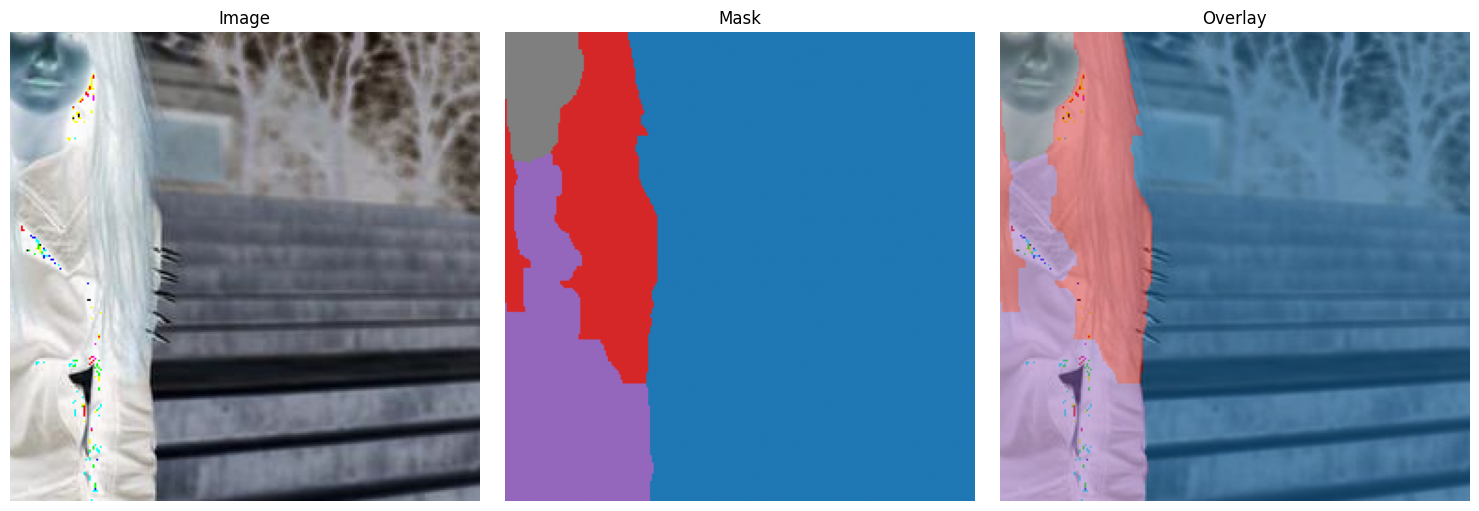


Sample 1:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 2, 13, 17, 38, 41, 48]


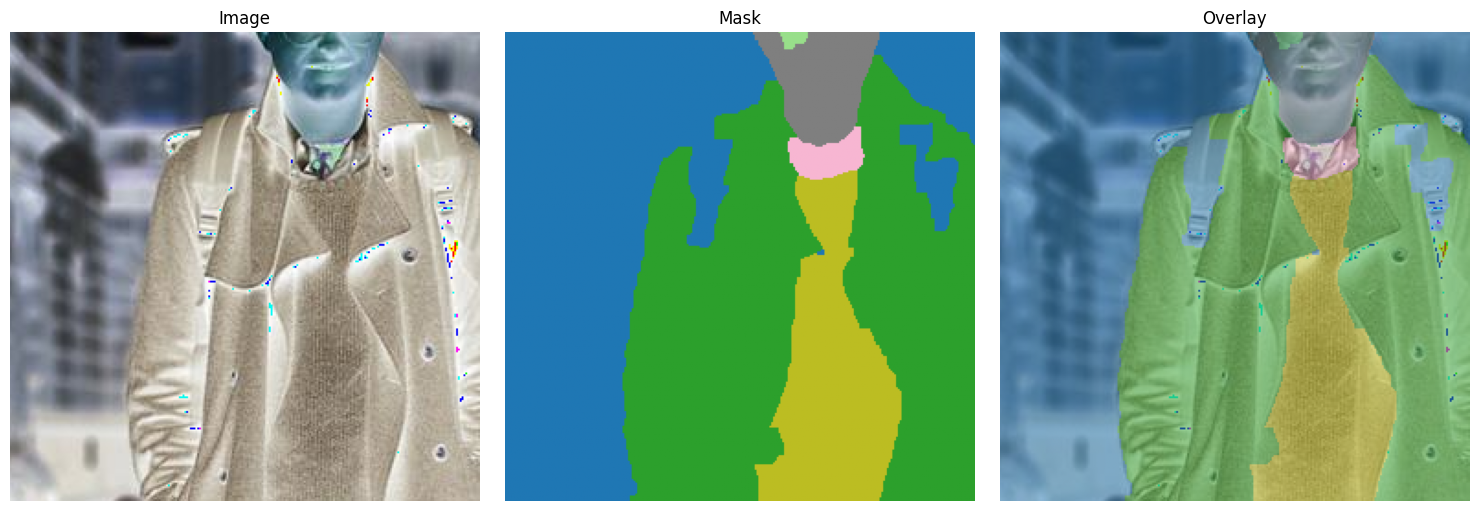


Sample 2:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique classes in mask: [0, 14, 19, 41, 47, 55]


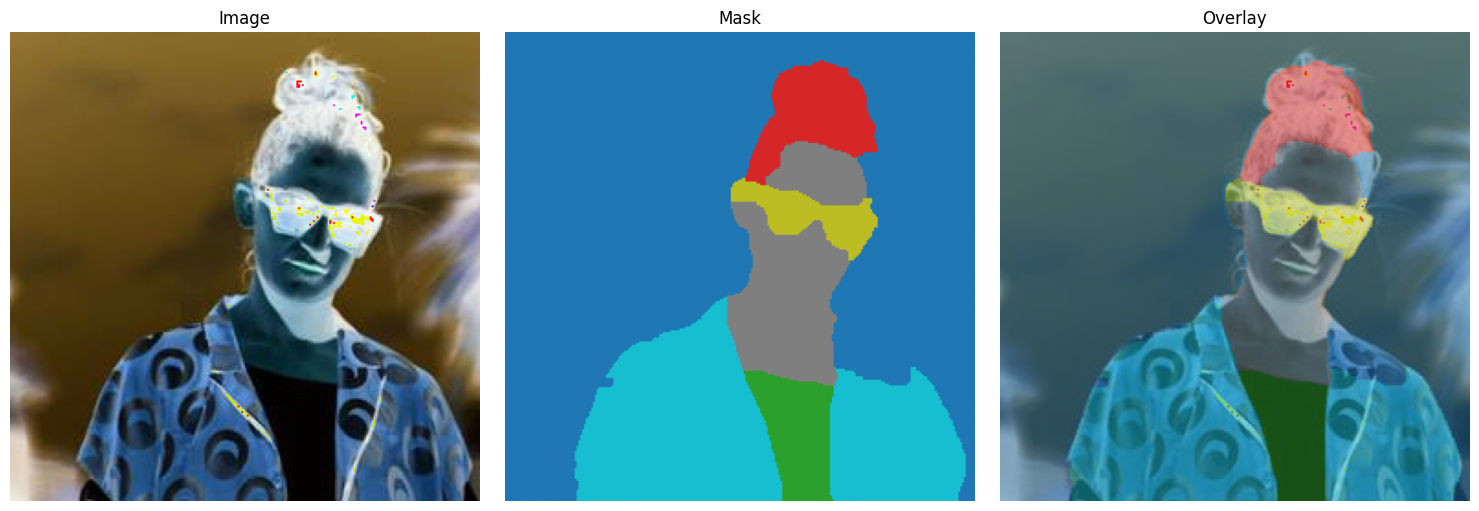

In [20]:
import glob
import pandas as pd
import os

# ============================================
# 1.  PREPARAR DATOS
# ============================================

DATA_DIR = 'clothes'

# Cargar imágenes
images = glob.glob('./clothes/*/images/*')
df = pd.DataFrame(images, columns=['image_path'])
df['mask_path'] = df. image_path.apply(lambda x: x.replace('/images/', '/labels/'). replace('.jpg', '.png'))
df['set'] = df.image_path.apply(lambda x: x.split('/')[2])

print(f"Total images: {len(df)}")
print(df['set'].value_counts())
print(df. head())

# Cargar diccionario de clases
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_names = class_dict['class_name'].tolist()
class_names[0] = 'background'  # Renombrar 'null' a 'background'
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

print('\n' + '='*50)
print('Dataset Classes:')
print('='*50)
for i, (name, rgb) in enumerate(zip(class_names, class_rgb_values)):
    print(f"{i:2d}. {name:20s} - RGB: {rgb}")
print('='*50 + '\n')

# ============================================
# 2. CREAR DATAMODULE
# ============================================

dm = DataModule(
    df=df,
    class_dict_path=os.path.join(DATA_DIR, 'class_dict.csv'),
    bs=16,
    ps=256,
    num_workers=4  # Ajusta según tu CPU
)

dm.setup()

print(f"Train samples: {len(dm.train_ds)}")
print(f"Valid samples: {len(dm. valid_ds)}")
print(f"Test samples: {len(dm.test_ds)}")
print(f"Number of classes: {dm.num_classes}")

# ============================================
# 3.  VISUALIZAR MUESTRAS
# ============================================
def denormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Desnormaliza una imagen normalizada con mean y std de ImageNet.
    
    Args:
        image (Tensor): Imagen normalizada (C, H, W)
        mean (list): Valores de media usados en normalización
        std (list): Valores de desviación estándar usados en normalización
    
    Returns:
        Tensor: Imagen desnormalizada en rango [0, 1]
    """
    # Asegurar que sea tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    
    # Crear tensores de mean y std con la forma correcta
    mean = torch.tensor(mean, dtype=image.dtype, device=image.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=image.dtype, device=image.device).view(3, 1, 1)
    
    # Desnormalizar: x = (x * std) + mean
    image = image * std + mean
    
    # Asegurar que esté en rango [0, 1]
    image = torch.clamp(image, 0, 1)
    
    return image

# Visualizar algunas muestras de entrenamiento
for i in range(3):
    x, y = dm.train_ds[i]
    print(f"\nSample {i}:")
    print(f"Image shape: {x.shape}")
    print(f"Mask shape: {y.shape}")
    print(f"Unique classes in mask: {torch.unique(y). tolist()}")

    # Asegurarse de que x sea un tensor de PyTorch antes de llamar a permute
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)

    dm.train_ds.__show_item__(x, y, denormalize=denormalize_image)

In [21]:
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [22]:
import os
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Configuration
ENCODER_NAME = 'efficientnet-b3'
LEARNING_RATE = 1e-3
MAX_EPOCHS = 30
BATCH_SIZE = 32
PATCH_SIZE = 224
CLASS_DICT_PATH = 'clothes/class_dict.csv'
NUM_WORKERS = 4

# Architectures to train
ARCHITECTURES = ['unet', 'deeplabv3', 'fpn', 'pspnet']

# Set random seed for reproducibility
pl.seed_everything(seed=42, workers=True)

# Load the data module once to get num_classes
data_module = DataModule(df, class_dict_path=CLASS_DICT_PATH, bs=BATCH_SIZE, ps=PATCH_SIZE, num_workers=NUM_WORKERS)
data_module.setup()
NUM_CLASSES = data_module.num_classes

# Train each architecture
for architecture in ARCHITECTURES:
    print(f"\n{'='*60}")
    print(f"Training {architecture.upper()}")
    print(f"{'='*60}\n")
    
    # Instantiate the SegmentationModel
    model = SegmentationModel(
        num_classes=NUM_CLASSES,
        encoder_name=ENCODER_NAME,
        encoder_weights='imagenet',
        learning_rate=LEARNING_RATE,
        architecture=architecture
    )
    
    # Define a CSV logger with folder structure
    csv_logger = CSVLogger(
        save_dir='experiments',
        name=architecture,
        version=None
    )
    
    # Define checkpoint callbacks
    checkpoint_val_loss = ModelCheckpoint(
        dirpath=f'experiments/{architecture}/checkpoints',
        filename='best_val_loss-{epoch:02d}-{val_loss:.4f}',
        monitor='val_loss',
        mode='min',
        save_top_k=1,
        verbose=True
    )
    
    # checkpoint_val_iou = ModelCheckpoint(
    #     dirpath=f'experiments/{architecture}/checkpoints',
    #     filename='best_val_iou-{epoch:02d}-{val_iou:.4f}',
    #     monitor='val_iou',
    #     mode='max',
    #     save_top_k=1,
    #     verbose=True
    # )
    
    # checkpoint_last = ModelCheckpoint(
    #     dirpath=f'experiments/{architecture}/checkpoints',
    #     filename='last-{epoch:02d}',
    #     save_last=True,
    #     verbose=True
    # )
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=MAX_EPOCHS,
        logger=csv_logger,
        callbacks=[checkpoint_val_loss],
        devices=1,
        deterministic=False,  # Use 'warn' instead of True for better compatibility
        log_every_n_steps=1
    )
    
    # Recreate data module for each architecture to ensure clean state
    arch_data_module = DataModule(df, class_dict_path=CLASS_DICT_PATH, bs=BATCH_SIZE, ps=PATCH_SIZE, num_workers=NUM_WORKERS)
    arch_data_module.setup()
    
    # Train the model
    trainer.fit(model, arch_data_module)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{architecture.upper()} training completed!")
    print(f"Best model (val_loss): {checkpoint_val_loss.best_model_path}")
    print(f"{'='*60}\n")

print("\n" + "="*60)
print("ALL ARCHITECTURES TRAINED SUCCESSFULLY!")
print("="*60)

Seed set to 42



Training UNET



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | Unet                   | 13.2 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | MulticlassF1Score      | 0      | train
-----------------------------------------------------------------------
13.2 M    Trainable params
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationW

Epoch 0 - Val Loss: 5.8584, Val Acc: 0.0011, Val IoU: 0.0006, Val Dice: 0.0012


/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationW

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarn

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 2.30578 (best 2.30578), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=00-val_loss=2.3058.ckpt' as top 1


Epoch 0 - Val Loss: 2.3023, Val Acc: 0.5808, Val IoU: 0.0379, Val Dice: 0.0471

Epoch 0 - Train Loss: 3.4695, Train Acc: 0.4199, Train IoU: 0.0186, Train Dice: 0.0271


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.95052 (best 1.95052), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=01-val_loss=1.9505.ckpt' as top 1


Epoch 1 - Val Loss: 1.9382, Val Acc: 0.6254, Val IoU: 0.0344, Val Dice: 0.0433

Epoch 1 - Train Loss: 2.1201, Train Acc: 0.6264, Train IoU: 0.0313, Train Dice: 0.0393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.84475 (best 1.84475), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=02-val_loss=1.8447.ckpt' as top 1


Epoch 2 - Val Loss: 1.8364, Val Acc: 0.6242, Val IoU: 0.0375, Val Dice: 0.0472

Epoch 2 - Train Loss: 1.8854, Train Acc: 0.6321, Train IoU: 0.0303, Train Dice: 0.0375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' reached 1.71014 (best 1.71014), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=03-val_loss=1.7101.ckpt' as top 1


Epoch 3 - Val Loss: 1.6888, Val Acc: 0.6431, Val IoU: 0.0413, Val Dice: 0.0504

Epoch 3 - Train Loss: 1.7681, Train Acc: 0.6547, Train IoU: 0.0331, Train Dice: 0.0405


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' reached 1.66776 (best 1.66776), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=04-val_loss=1.6678.ckpt' as top 1


Epoch 4 - Val Loss: 1.6753, Val Acc: 0.6474, Val IoU: 0.0409, Val Dice: 0.0503

Epoch 4 - Train Loss: 1.7506, Train Acc: 0.6514, Train IoU: 0.0360, Train Dice: 0.0450


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1


Epoch 5 - Val Loss: 1.6729, Val Acc: 0.6656, Val IoU: 0.0480, Val Dice: 0.0612

Epoch 5 - Train Loss: 1.7061, Train Acc: 0.6589, Train IoU: 0.0403, Train Dice: 0.0514


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' was not in top 1


Epoch 6 - Val Loss: 1.7448, Val Acc: 0.6491, Val IoU: 0.0477, Val Dice: 0.0626

Epoch 6 - Train Loss: 1.6811, Train Acc: 0.6617, Train IoU: 0.0421, Train Dice: 0.0536


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' reached 1.60558 (best 1.60558), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=07-val_loss=1.6056.ckpt' as top 1


Epoch 7 - Val Loss: 1.5982, Val Acc: 0.6586, Val IoU: 0.0556, Val Dice: 0.0713

Epoch 7 - Train Loss: 1.6717, Train Acc: 0.6692, Train IoU: 0.0467, Train Dice: 0.0605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1


Epoch 8 - Val Loss: 1.6378, Val Acc: 0.6483, Val IoU: 0.0566, Val Dice: 0.0741

Epoch 8 - Train Loss: 1.6710, Train Acc: 0.6672, Train IoU: 0.0484, Train Dice: 0.0642


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1


Epoch 9 - Val Loss: 1.6171, Val Acc: 0.6657, Val IoU: 0.0561, Val Dice: 0.0710

Epoch 9 - Train Loss: 1.5952, Train Acc: 0.6944, Train IoU: 0.0528, Train Dice: 0.0690


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1


Epoch 10 - Val Loss: 1.6295, Val Acc: 0.6652, Val IoU: 0.0599, Val Dice: 0.0778

Epoch 10 - Train Loss: 1.6102, Train Acc: 0.6770, Train IoU: 0.0515, Train Dice: 0.0678


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' reached 1.59237 (best 1.59237), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=11-val_loss=1.5924.ckpt' as top 1


Epoch 11 - Val Loss: 1.5759, Val Acc: 0.6717, Val IoU: 0.0684, Val Dice: 0.0932

Epoch 11 - Train Loss: 1.5760, Train Acc: 0.6829, Train IoU: 0.0533, Train Dice: 0.0716


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' reached 1.52184 (best 1.52184), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=12-val_loss=1.5218.ckpt' as top 1


Epoch 12 - Val Loss: 1.5252, Val Acc: 0.6983, Val IoU: 0.0683, Val Dice: 0.0924

Epoch 12 - Train Loss: 1.5128, Train Acc: 0.6996, Train IoU: 0.0595, Train Dice: 0.0796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1


Epoch 13 - Val Loss: 1.5792, Val Acc: 0.6777, Val IoU: 0.0769, Val Dice: 0.1005

Epoch 13 - Train Loss: 1.4992, Train Acc: 0.7057, Train IoU: 0.0618, Train Dice: 0.0824


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' reached 1.46825 (best 1.46825), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=14-val_loss=1.4683.ckpt' as top 1


Epoch 14 - Val Loss: 1.4689, Val Acc: 0.7086, Val IoU: 0.0756, Val Dice: 0.0988

Epoch 14 - Train Loss: 1.5179, Train Acc: 0.6934, Train IoU: 0.0625, Train Dice: 0.0828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' reached 1.41490 (best 1.41490), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=15-val_loss=1.4149.ckpt' as top 1


Epoch 15 - Val Loss: 1.4070, Val Acc: 0.7168, Val IoU: 0.0784, Val Dice: 0.1032

Epoch 15 - Train Loss: 1.4773, Train Acc: 0.7037, Train IoU: 0.0697, Train Dice: 0.0940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' reached 1.38768 (best 1.38768), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=16-val_loss=1.3877.ckpt' as top 1


Epoch 16 - Val Loss: 1.3964, Val Acc: 0.6983, Val IoU: 0.0941, Val Dice: 0.1227

Epoch 16 - Train Loss: 1.4640, Train Acc: 0.7059, Train IoU: 0.0692, Train Dice: 0.0937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1


Epoch 17 - Val Loss: 1.4328, Val Acc: 0.7007, Val IoU: 0.0905, Val Dice: 0.1215

Epoch 17 - Train Loss: 1.4445, Train Acc: 0.7045, Train IoU: 0.0751, Train Dice: 0.1006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' reached 1.38270 (best 1.38270), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=18-val_loss=1.3827.ckpt' as top 1


Epoch 18 - Val Loss: 1.3887, Val Acc: 0.7322, Val IoU: 0.0947, Val Dice: 0.1263

Epoch 18 - Train Loss: 1.3654, Train Acc: 0.7417, Train IoU: 0.0819, Train Dice: 0.1111


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1


Epoch 19 - Val Loss: 1.3965, Val Acc: 0.7240, Val IoU: 0.0948, Val Dice: 0.1260

Epoch 19 - Train Loss: 1.3915, Train Acc: 0.7269, Train IoU: 0.0857, Train Dice: 0.1151


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1


Epoch 20 - Val Loss: 1.4928, Val Acc: 0.6974, Val IoU: 0.0898, Val Dice: 0.1210

Epoch 20 - Train Loss: 1.3393, Train Acc: 0.7453, Train IoU: 0.0823, Train Dice: 0.1104


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1


Epoch 21 - Val Loss: 1.4638, Val Acc: 0.7178, Val IoU: 0.0999, Val Dice: 0.1332

Epoch 21 - Train Loss: 1.3318, Train Acc: 0.7409, Train IoU: 0.0914, Train Dice: 0.1222


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1


Epoch 22 - Val Loss: 1.4089, Val Acc: 0.7313, Val IoU: 0.1073, Val Dice: 0.1423

Epoch 22 - Train Loss: 1.3623, Train Acc: 0.7315, Train IoU: 0.0899, Train Dice: 0.1208


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' was not in top 1


Epoch 23 - Val Loss: 1.4952, Val Acc: 0.7135, Val IoU: 0.1149, Val Dice: 0.1545

Epoch 23 - Train Loss: 1.3790, Train Acc: 0.7359, Train IoU: 0.0896, Train Dice: 0.1189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1


Epoch 24 - Val Loss: 1.3949, Val Acc: 0.7129, Val IoU: 0.0997, Val Dice: 0.1341

Epoch 24 - Train Loss: 1.3608, Train Acc: 0.7399, Train IoU: 0.0928, Train Dice: 0.1239


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' reached 1.21804 (best 1.21804), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=25-val_loss=1.2180.ckpt' as top 1


Epoch 25 - Val Loss: 1.2132, Val Acc: 0.7626, Val IoU: 0.1264, Val Dice: 0.1662

Epoch 25 - Train Loss: 1.2770, Train Acc: 0.7529, Train IoU: 0.0960, Train Dice: 0.1269


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1


Epoch 26 - Val Loss: 1.2324, Val Acc: 0.7589, Val IoU: 0.1285, Val Dice: 0.1682

Epoch 26 - Train Loss: 1.2502, Train Acc: 0.7638, Train IoU: 0.1033, Train Dice: 0.1353


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1


Epoch 27 - Val Loss: 1.3872, Val Acc: 0.7112, Val IoU: 0.1102, Val Dice: 0.1470

Epoch 27 - Train Loss: 1.3113, Train Acc: 0.7473, Train IoU: 0.1031, Train Dice: 0.1359


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1


Epoch 28 - Val Loss: 1.2406, Val Acc: 0.7478, Val IoU: 0.1176, Val Dice: 0.1507

Epoch 28 - Train Loss: 1.2410, Train Acc: 0.7645, Train IoU: 0.1044, Train Dice: 0.1362


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29 - Val Loss: 1.3380, Val Acc: 0.7158, Val IoU: 0.1180, Val Dice: 0.1536

Epoch 29 - Train Loss: 1.2245, Train Acc: 0.7593, Train IoU: 0.1055, Train Dice: 0.1370


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



UNET training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/unet/checkpoints/best_val_loss-epoch=25-val_loss=1.2180.ckpt


Training DEEPLABV3




  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | DeepLabV3              | 14.5 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | MulticlassF1Score      | 0      | train
-----------------------------------------------------------------------
14.5 M    Trainable params
0         Non-trainable params
14.5 M    Total params
57.933    Total estimated model params size (MB)
445       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 4.6235, Val Acc: 0.0040, Val IoU: 0.0009, Val Dice: 0.0019


/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationW

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWar

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 1.97768 (best 1.97768), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=00-val_loss=1.9777.ckpt' as top 1


Epoch 0 - Val Loss: 1.9793, Val Acc: 0.6363, Val IoU: 0.0546, Val Dice: 0.0759

Epoch 0 - Train Loss: 2.6008, Train Acc: 0.5757, Train IoU: 0.0289, Train Dice: 0.0420


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.80522 (best 1.80522), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=01-val_loss=1.8052.ckpt' as top 1


Epoch 1 - Val Loss: 1.7956, Val Acc: 0.6508, Val IoU: 0.0503, Val Dice: 0.0732

Epoch 1 - Train Loss: 1.7611, Train Acc: 0.6735, Train IoU: 0.0474, Train Dice: 0.0660


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.43555 (best 1.43555), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=02-val_loss=1.4355.ckpt' as top 1


Epoch 2 - Val Loss: 1.4226, Val Acc: 0.7335, Val IoU: 0.0763, Val Dice: 0.1073

Epoch 2 - Train Loss: 1.5682, Train Acc: 0.6959, Train IoU: 0.0665, Train Dice: 0.0937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' was not in top 1


Epoch 3 - Val Loss: 1.5433, Val Acc: 0.6974, Val IoU: 0.0934, Val Dice: 0.1342

Epoch 3 - Train Loss: 1.4291, Train Acc: 0.7309, Train IoU: 0.0819, Train Dice: 0.1143


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' was not in top 1


Epoch 4 - Val Loss: 1.4659, Val Acc: 0.7035, Val IoU: 0.0986, Val Dice: 0.1382

Epoch 4 - Train Loss: 1.4395, Train Acc: 0.7199, Train IoU: 0.0879, Train Dice: 0.1247


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1


Epoch 5 - Val Loss: 1.5306, Val Acc: 0.6866, Val IoU: 0.0955, Val Dice: 0.1374

Epoch 5 - Train Loss: 1.3327, Train Acc: 0.7415, Train IoU: 0.1000, Train Dice: 0.1408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' reached 1.30709 (best 1.30709), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=06-val_loss=1.3071.ckpt' as top 1


Epoch 6 - Val Loss: 1.2936, Val Acc: 0.7302, Val IoU: 0.1018, Val Dice: 0.1441

Epoch 6 - Train Loss: 1.3114, Train Acc: 0.7366, Train IoU: 0.0982, Train Dice: 0.1368


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' was not in top 1


Epoch 7 - Val Loss: 1.4445, Val Acc: 0.7079, Val IoU: 0.1278, Val Dice: 0.1756

Epoch 7 - Train Loss: 1.2028, Train Acc: 0.7724, Train IoU: 0.1151, Train Dice: 0.1593


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1


Epoch 8 - Val Loss: 1.4381, Val Acc: 0.7081, Val IoU: 0.1216, Val Dice: 0.1746

Epoch 8 - Train Loss: 1.2231, Train Acc: 0.7591, Train IoU: 0.1152, Train Dice: 0.1614


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1


Epoch 9 - Val Loss: 1.3354, Val Acc: 0.7353, Val IoU: 0.1226, Val Dice: 0.1739

Epoch 9 - Train Loss: 1.2029, Train Acc: 0.7673, Train IoU: 0.1263, Train Dice: 0.1760


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1


Epoch 10 - Val Loss: 1.4757, Val Acc: 0.6956, Val IoU: 0.1235, Val Dice: 0.1732

Epoch 10 - Train Loss: 1.2141, Train Acc: 0.7570, Train IoU: 0.1223, Train Dice: 0.1690


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1


Epoch 11 - Val Loss: 1.3798, Val Acc: 0.7069, Val IoU: 0.1306, Val Dice: 0.1856

Epoch 11 - Train Loss: 1.2013, Train Acc: 0.7659, Train IoU: 0.1332, Train Dice: 0.1867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' was not in top 1


Epoch 12 - Val Loss: 1.3168, Val Acc: 0.7455, Val IoU: 0.1527, Val Dice: 0.2107

Epoch 12 - Train Loss: 1.0951, Train Acc: 0.7900, Train IoU: 0.1547, Train Dice: 0.2135


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' reached 1.22582 (best 1.22582), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=13-val_loss=1.2258.ckpt' as top 1


Epoch 13 - Val Loss: 1.2206, Val Acc: 0.7569, Val IoU: 0.1667, Val Dice: 0.2341

Epoch 13 - Train Loss: 1.0991, Train Acc: 0.7891, Train IoU: 0.1531, Train Dice: 0.2122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' reached 1.18318 (best 1.18318), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=14-val_loss=1.1832.ckpt' as top 1


Epoch 14 - Val Loss: 1.1901, Val Acc: 0.7482, Val IoU: 0.1622, Val Dice: 0.2269

Epoch 14 - Train Loss: 1.0365, Train Acc: 0.7964, Train IoU: 0.1613, Train Dice: 0.2225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' reached 1.15938 (best 1.15938), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=15-val_loss=1.1594.ckpt' as top 1


Epoch 15 - Val Loss: 1.1512, Val Acc: 0.7559, Val IoU: 0.1866, Val Dice: 0.2582

Epoch 15 - Train Loss: 1.0086, Train Acc: 0.8046, Train IoU: 0.1877, Train Dice: 0.2587


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1


Epoch 16 - Val Loss: 1.3387, Val Acc: 0.7348, Val IoU: 0.1750, Val Dice: 0.2428

Epoch 16 - Train Loss: 1.0254, Train Acc: 0.8029, Train IoU: 0.1801, Train Dice: 0.2457


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' reached 1.11301 (best 1.11301), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=17-val_loss=1.1130.ckpt' as top 1


Epoch 17 - Val Loss: 1.1031, Val Acc: 0.7802, Val IoU: 0.1833, Val Dice: 0.2481

Epoch 17 - Train Loss: 0.9501, Train Acc: 0.8241, Train IoU: 0.1933, Train Dice: 0.2586


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' was not in top 1


Epoch 18 - Val Loss: 1.1899, Val Acc: 0.7764, Val IoU: 0.1852, Val Dice: 0.2560

Epoch 18 - Train Loss: 0.9179, Train Acc: 0.8233, Train IoU: 0.1906, Train Dice: 0.2557


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' reached 1.11134 (best 1.11134), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=19-val_loss=1.1113.ckpt' as top 1


Epoch 19 - Val Loss: 1.1010, Val Acc: 0.7804, Val IoU: 0.1913, Val Dice: 0.2634

Epoch 19 - Train Loss: 0.9505, Train Acc: 0.8222, Train IoU: 0.1946, Train Dice: 0.2641


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1


Epoch 20 - Val Loss: 1.2294, Val Acc: 0.7535, Val IoU: 0.1482, Val Dice: 0.2032

Epoch 20 - Train Loss: 0.9074, Train Acc: 0.8308, Train IoU: 0.2029, Train Dice: 0.2726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1


Epoch 21 - Val Loss: 1.1741, Val Acc: 0.7727, Val IoU: 0.1533, Val Dice: 0.2121

Epoch 21 - Train Loss: 0.9455, Train Acc: 0.8240, Train IoU: 0.2022, Train Dice: 0.2726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1


Epoch 22 - Val Loss: 1.1983, Val Acc: 0.7546, Val IoU: 0.1733, Val Dice: 0.2395

Epoch 22 - Train Loss: 0.9459, Train Acc: 0.8215, Train IoU: 0.2038, Train Dice: 0.2765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' was not in top 1


Epoch 23 - Val Loss: 1.2093, Val Acc: 0.7638, Val IoU: 0.1705, Val Dice: 0.2382

Epoch 23 - Train Loss: 0.8742, Train Acc: 0.8378, Train IoU: 0.2200, Train Dice: 0.2923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1


Epoch 24 - Val Loss: 1.1948, Val Acc: 0.7569, Val IoU: 0.1934, Val Dice: 0.2652

Epoch 24 - Train Loss: 0.8691, Train Acc: 0.8407, Train IoU: 0.2164, Train Dice: 0.2905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1


Epoch 25 - Val Loss: 1.2272, Val Acc: 0.7513, Val IoU: 0.1958, Val Dice: 0.2682

Epoch 25 - Train Loss: 0.8611, Train Acc: 0.8397, Train IoU: 0.2350, Train Dice: 0.3134


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1


Epoch 26 - Val Loss: 1.0986, Val Acc: 0.7826, Val IoU: 0.2114, Val Dice: 0.2892

Epoch 26 - Train Loss: 0.8156, Train Acc: 0.8514, Train IoU: 0.2486, Train Dice: 0.3239


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1


Epoch 27 - Val Loss: 1.1859, Val Acc: 0.7652, Val IoU: 0.1895, Val Dice: 0.2571

Epoch 27 - Train Loss: 0.8064, Train Acc: 0.8510, Train IoU: 0.2429, Train Dice: 0.3209


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1


Epoch 28 - Val Loss: 1.2096, Val Acc: 0.7816, Val IoU: 0.2226, Val Dice: 0.2983

Epoch 28 - Train Loss: 0.7726, Train Acc: 0.8645, Train IoU: 0.2613, Train Dice: 0.3379


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29 - Val Loss: 1.1842, Val Acc: 0.7643, Val IoU: 0.2092, Val Dice: 0.2926

Epoch 29 - Train Loss: 0.7487, Train Acc: 0.8649, Train IoU: 0.2721, Train Dice: 0.3516


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



DEEPLABV3 training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/deeplabv3/checkpoints/best_val_loss-epoch=19-val_loss=1.1113.ckpt


Training FPN




  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | FPN                    | 12.5 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | MulticlassF1Score      | 0      | train
-----------------------------------------------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
49.929    Total estimated model params size (MB)
467       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 6.5513, Val Acc: 0.0125, Val IoU: 0.0016, Val Dice: 0.0031


/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWa

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  y = imread(r.mask_path)


Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 1.84003 (best 1.84003), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=00-val_loss=1.8400.ckpt' as top 1


Epoch 0 - Val Loss: 1.8336, Val Acc: 0.6605, Val IoU: 0.0522, Val Dice: 0.0730

Epoch 0 - Train Loss: 2.4570, Train Acc: 0.5968, Train IoU: 0.0327, Train Dice: 0.0477


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 1.42969 (best 1.42969), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=01-val_loss=1.4297.ckpt' as top 1


Epoch 1 - Val Loss: 1.4310, Val Acc: 0.7273, Val IoU: 0.0903, Val Dice: 0.1258

Epoch 1 - Train Loss: 1.6439, Train Acc: 0.6998, Train IoU: 0.0671, Train Dice: 0.0961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.39232 (best 1.39232), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=02-val_loss=1.3923.ckpt' as top 1


Epoch 2 - Val Loss: 1.3920, Val Acc: 0.7293, Val IoU: 0.1083, Val Dice: 0.1521

Epoch 2 - Train Loss: 1.5341, Train Acc: 0.7096, Train IoU: 0.0799, Train Dice: 0.1128


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' was not in top 1


Epoch 3 - Val Loss: 1.3990, Val Acc: 0.7260, Val IoU: 0.1183, Val Dice: 0.1642

Epoch 3 - Train Loss: 1.4267, Train Acc: 0.7233, Train IoU: 0.0948, Train Dice: 0.1330


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' reached 1.38564 (best 1.38564), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=04-val_loss=1.3856.ckpt' as top 1


Epoch 4 - Val Loss: 1.3684, Val Acc: 0.7206, Val IoU: 0.1266, Val Dice: 0.1778

Epoch 4 - Train Loss: 1.3537, Train Acc: 0.7421, Train IoU: 0.1069, Train Dice: 0.1513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' was not in top 1


Epoch 5 - Val Loss: 1.3713, Val Acc: 0.7337, Val IoU: 0.1250, Val Dice: 0.1748

Epoch 5 - Train Loss: 1.2740, Train Acc: 0.7547, Train IoU: 0.1197, Train Dice: 0.1704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' was not in top 1


Epoch 6 - Val Loss: 1.4124, Val Acc: 0.7208, Val IoU: 0.1300, Val Dice: 0.1809

Epoch 6 - Train Loss: 1.2299, Train Acc: 0.7564, Train IoU: 0.1288, Train Dice: 0.1843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' reached 1.24856 (best 1.24856), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=07-val_loss=1.2486.ckpt' as top 1


Epoch 7 - Val Loss: 1.2584, Val Acc: 0.7524, Val IoU: 0.1497, Val Dice: 0.2098

Epoch 7 - Train Loss: 1.3139, Train Acc: 0.7466, Train IoU: 0.1281, Train Dice: 0.1810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1


Epoch 8 - Val Loss: 1.3538, Val Acc: 0.7354, Val IoU: 0.1490, Val Dice: 0.2092

Epoch 8 - Train Loss: 1.2393, Train Acc: 0.7605, Train IoU: 0.1404, Train Dice: 0.1987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' was not in top 1


Epoch 9 - Val Loss: 1.3407, Val Acc: 0.7348, Val IoU: 0.1385, Val Dice: 0.1915

Epoch 9 - Train Loss: 1.1950, Train Acc: 0.7684, Train IoU: 0.1465, Train Dice: 0.2072


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' was not in top 1


Epoch 10 - Val Loss: 1.3053, Val Acc: 0.7554, Val IoU: 0.1484, Val Dice: 0.2086

Epoch 10 - Train Loss: 1.1890, Train Acc: 0.7676, Train IoU: 0.1496, Train Dice: 0.2112


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' reached 1.24387 (best 1.24387), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=11-val_loss=1.2439.ckpt' as top 1


Epoch 11 - Val Loss: 1.2360, Val Acc: 0.7641, Val IoU: 0.1668, Val Dice: 0.2280

Epoch 11 - Train Loss: 1.1369, Train Acc: 0.7802, Train IoU: 0.1720, Train Dice: 0.2407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' reached 1.21707 (best 1.21707), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=12-val_loss=1.2171.ckpt' as top 1


Epoch 12 - Val Loss: 1.2047, Val Acc: 0.7663, Val IoU: 0.1724, Val Dice: 0.2426

Epoch 12 - Train Loss: 1.1084, Train Acc: 0.7883, Train IoU: 0.1768, Train Dice: 0.2507


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1


Epoch 13 - Val Loss: 1.3620, Val Acc: 0.7401, Val IoU: 0.1736, Val Dice: 0.2414

Epoch 13 - Train Loss: 1.0865, Train Acc: 0.7907, Train IoU: 0.1878, Train Dice: 0.2646


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1


Epoch 14 - Val Loss: 1.2302, Val Acc: 0.7461, Val IoU: 0.1817, Val Dice: 0.2558

Epoch 14 - Train Loss: 1.0529, Train Acc: 0.8050, Train IoU: 0.1883, Train Dice: 0.2629


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' was not in top 1


Epoch 15 - Val Loss: 1.3543, Val Acc: 0.7389, Val IoU: 0.1877, Val Dice: 0.2586

Epoch 15 - Train Loss: 0.9959, Train Acc: 0.8107, Train IoU: 0.1977, Train Dice: 0.2760


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1


Epoch 16 - Val Loss: 1.3879, Val Acc: 0.7190, Val IoU: 0.1715, Val Dice: 0.2440

Epoch 16 - Train Loss: 1.0190, Train Acc: 0.8067, Train IoU: 0.1859, Train Dice: 0.2565


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1


Epoch 17 - Val Loss: 1.3558, Val Acc: 0.7459, Val IoU: 0.1999, Val Dice: 0.2767

Epoch 17 - Train Loss: 0.9950, Train Acc: 0.8102, Train IoU: 0.2189, Train Dice: 0.3023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' was not in top 1


Epoch 18 - Val Loss: 1.2820, Val Acc: 0.7490, Val IoU: 0.1554, Val Dice: 0.2188

Epoch 18 - Train Loss: 1.0229, Train Acc: 0.8085, Train IoU: 0.2014, Train Dice: 0.2775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1


Epoch 19 - Val Loss: 1.2458, Val Acc: 0.7649, Val IoU: 0.1649, Val Dice: 0.2250

Epoch 19 - Train Loss: 0.9946, Train Acc: 0.8184, Train IoU: 0.2073, Train Dice: 0.2856


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' was not in top 1


Epoch 20 - Val Loss: 1.2805, Val Acc: 0.7583, Val IoU: 0.1796, Val Dice: 0.2493

Epoch 20 - Train Loss: 0.9014, Train Acc: 0.8323, Train IoU: 0.2423, Train Dice: 0.3287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' reached 1.12178 (best 1.12178), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=21-val_loss=1.1218.ckpt' as top 1


Epoch 21 - Val Loss: 1.1192, Val Acc: 0.7861, Val IoU: 0.2014, Val Dice: 0.2705

Epoch 21 - Train Loss: 0.8672, Train Acc: 0.8434, Train IoU: 0.2530, Train Dice: 0.3375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' reached 1.11003 (best 1.11003), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=22-val_loss=1.1100.ckpt' as top 1


Epoch 22 - Val Loss: 1.1205, Val Acc: 0.7964, Val IoU: 0.2169, Val Dice: 0.2959

Epoch 22 - Train Loss: 0.8471, Train Acc: 0.8442, Train IoU: 0.2485, Train Dice: 0.3354


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' was not in top 1


Epoch 23 - Val Loss: 1.2172, Val Acc: 0.7766, Val IoU: 0.2040, Val Dice: 0.2768

Epoch 23 - Train Loss: 0.8130, Train Acc: 0.8565, Train IoU: 0.2634, Train Dice: 0.3488


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1


Epoch 24 - Val Loss: 1.2497, Val Acc: 0.7675, Val IoU: 0.2022, Val Dice: 0.2773

Epoch 24 - Train Loss: 0.7826, Train Acc: 0.8564, Train IoU: 0.2658, Train Dice: 0.3504


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1


Epoch 25 - Val Loss: 1.2947, Val Acc: 0.7553, Val IoU: 0.2047, Val Dice: 0.2756

Epoch 25 - Train Loss: 0.7732, Train Acc: 0.8625, Train IoU: 0.2887, Train Dice: 0.3804


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' was not in top 1


Epoch 26 - Val Loss: 1.1886, Val Acc: 0.7742, Val IoU: 0.1949, Val Dice: 0.2659

Epoch 26 - Train Loss: 0.7290, Train Acc: 0.8685, Train IoU: 0.2801, Train Dice: 0.3678


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1


Epoch 27 - Val Loss: 1.1720, Val Acc: 0.7834, Val IoU: 0.2217, Val Dice: 0.2990

Epoch 27 - Train Loss: 0.7272, Train Acc: 0.8700, Train IoU: 0.2994, Train Dice: 0.3953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1


Epoch 28 - Val Loss: 1.3494, Val Acc: 0.7525, Val IoU: 0.2102, Val Dice: 0.2944

Epoch 28 - Train Loss: 0.7170, Train Acc: 0.8702, Train IoU: 0.3003, Train Dice: 0.3913


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29 - Val Loss: 1.2396, Val Acc: 0.7722, Val IoU: 0.2025, Val Dice: 0.2732

Epoch 29 - Train Loss: 0.7188, Train Acc: 0.8768, Train IoU: 0.3056, Train Dice: 0.3950


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | loss_fn             | DiceLoss               | 0      | train
1 | ce_loss             | CrossEntropyLoss       | 0      | train
2 | model               | PSPNet                 | 11.0 M | train
3 | train_iou           | MulticlassJaccardIndex | 0      | train
4 | val_iou             | MulticlassJaccardIndex | 0      | train
5 | train_iou_per_class | MulticlassJaccardIndex | 0      | train
6 | val_iou_per_class   | MulticlassJaccardIndex | 0      | train
7 | train_dice          | MulticlassF1Score      | 0      | train
8 | val_dice            | MulticlassF1Score      | 0      | train
-----------------------------------------------------------------------
11.0 M    Trainable params
0         


FPN training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/fpn/checkpoints/best_val_loss-epoch=22-val_loss=1.1100.ckpt


Training PSPNET



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationW

Epoch 0 - Val Loss: 14.5432, Val Acc: 0.0122, Val IoU: 0.0020, Val Dice: 0.0038


/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(r.image_path)
/tmp/ipykernel_453061/2253632455.py:89: DeprecationW

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 22: 'val_loss' reached 2.23728 (best 2.23728), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=00-val_loss=2.2373.ckpt' as top 1


Epoch 0 - Val Loss: 2.2279, Val Acc: 0.6036, Val IoU: 0.0293, Val Dice: 0.0411

Epoch 0 - Train Loss: 2.6242, Train Acc: 0.5324, Train IoU: 0.0209, Train Dice: 0.0316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 44: 'val_loss' reached 2.06699 (best 2.06699), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=01-val_loss=2.0670.ckpt' as top 1


Epoch 1 - Val Loss: 2.0591, Val Acc: 0.6345, Val IoU: 0.0519, Val Dice: 0.0757

Epoch 1 - Train Loss: 1.9273, Train Acc: 0.6254, Train IoU: 0.0447, Train Dice: 0.0656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 66: 'val_loss' reached 1.85824 (best 1.85824), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=02-val_loss=1.8582.ckpt' as top 1


Epoch 2 - Val Loss: 1.8546, Val Acc: 0.6638, Val IoU: 0.0602, Val Dice: 0.0883

Epoch 2 - Train Loss: 1.8375, Train Acc: 0.6392, Train IoU: 0.0539, Train Dice: 0.0797


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 88: 'val_loss' reached 1.76352 (best 1.76352), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=03-val_loss=1.7635.ckpt' as top 1


Epoch 3 - Val Loss: 1.7739, Val Acc: 0.6679, Val IoU: 0.0660, Val Dice: 0.0980

Epoch 3 - Train Loss: 1.7206, Train Acc: 0.6579, Train IoU: 0.0605, Train Dice: 0.0889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 110: 'val_loss' was not in top 1


Epoch 4 - Val Loss: 1.7987, Val Acc: 0.6520, Val IoU: 0.0733, Val Dice: 0.1097

Epoch 4 - Train Loss: 1.7363, Train Acc: 0.6568, Train IoU: 0.0671, Train Dice: 0.0993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 132: 'val_loss' reached 1.72365 (best 1.72365), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=05-val_loss=1.7236.ckpt' as top 1


Epoch 5 - Val Loss: 1.7415, Val Acc: 0.6614, Val IoU: 0.0786, Val Dice: 0.1141

Epoch 5 - Train Loss: 1.6237, Train Acc: 0.6709, Train IoU: 0.0748, Train Dice: 0.1107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 154: 'val_loss' reached 1.64138 (best 1.64138), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=06-val_loss=1.6414.ckpt' as top 1


Epoch 6 - Val Loss: 1.6452, Val Acc: 0.6740, Val IoU: 0.0961, Val Dice: 0.1377

Epoch 6 - Train Loss: 1.5283, Train Acc: 0.6944, Train IoU: 0.0823, Train Dice: 0.1225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 176: 'val_loss' was not in top 1


Epoch 7 - Val Loss: 1.7467, Val Acc: 0.6518, Val IoU: 0.0964, Val Dice: 0.1397

Epoch 7 - Train Loss: 1.5711, Train Acc: 0.6858, Train IoU: 0.0846, Train Dice: 0.1255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 198: 'val_loss' was not in top 1


Epoch 8 - Val Loss: 1.7980, Val Acc: 0.6299, Val IoU: 0.0902, Val Dice: 0.1325

Epoch 8 - Train Loss: 1.5942, Train Acc: 0.6776, Train IoU: 0.0890, Train Dice: 0.1319


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 220: 'val_loss' reached 1.54883 (best 1.54883), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=09-val_loss=1.5488.ckpt' as top 1


Epoch 9 - Val Loss: 1.5340, Val Acc: 0.6850, Val IoU: 0.0948, Val Dice: 0.1373

Epoch 9 - Train Loss: 1.6277, Train Acc: 0.6713, Train IoU: 0.0872, Train Dice: 0.1281


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 242: 'val_loss' reached 1.49649 (best 1.49649), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=10-val_loss=1.4965.ckpt' as top 1


Epoch 10 - Val Loss: 1.5084, Val Acc: 0.6898, Val IoU: 0.1017, Val Dice: 0.1467

Epoch 10 - Train Loss: 1.5068, Train Acc: 0.7022, Train IoU: 0.0937, Train Dice: 0.1366


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 264: 'val_loss' was not in top 1


Epoch 11 - Val Loss: 1.6329, Val Acc: 0.6771, Val IoU: 0.1132, Val Dice: 0.1637

Epoch 11 - Train Loss: 1.5102, Train Acc: 0.6963, Train IoU: 0.0983, Train Dice: 0.1453


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 286: 'val_loss' was not in top 1


Epoch 12 - Val Loss: 1.6216, Val Acc: 0.6593, Val IoU: 0.1059, Val Dice: 0.1481

Epoch 12 - Train Loss: 1.5020, Train Acc: 0.6895, Train IoU: 0.0971, Train Dice: 0.1443


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 308: 'val_loss' was not in top 1


Epoch 13 - Val Loss: 1.6183, Val Acc: 0.6762, Val IoU: 0.0969, Val Dice: 0.1405

Epoch 13 - Train Loss: 1.4917, Train Acc: 0.7017, Train IoU: 0.0992, Train Dice: 0.1458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 330: 'val_loss' was not in top 1


Epoch 14 - Val Loss: 1.6658, Val Acc: 0.6589, Val IoU: 0.1160, Val Dice: 0.1674

Epoch 14 - Train Loss: 1.4221, Train Acc: 0.7150, Train IoU: 0.1115, Train Dice: 0.1650


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 352: 'val_loss' was not in top 1


Epoch 15 - Val Loss: 1.5208, Val Acc: 0.7093, Val IoU: 0.1081, Val Dice: 0.1540

Epoch 15 - Train Loss: 1.4500, Train Acc: 0.7068, Train IoU: 0.1110, Train Dice: 0.1640


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 374: 'val_loss' was not in top 1


Epoch 16 - Val Loss: 1.5168, Val Acc: 0.7071, Val IoU: 0.1058, Val Dice: 0.1511

Epoch 16 - Train Loss: 1.3464, Train Acc: 0.7308, Train IoU: 0.1138, Train Dice: 0.1663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 396: 'val_loss' was not in top 1


Epoch 17 - Val Loss: 1.5550, Val Acc: 0.6782, Val IoU: 0.1306, Val Dice: 0.1837

Epoch 17 - Train Loss: 1.3867, Train Acc: 0.7194, Train IoU: 0.1192, Train Dice: 0.1772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 418: 'val_loss' reached 1.45553 (best 1.45553), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=18-val_loss=1.4555.ckpt' as top 1


Epoch 18 - Val Loss: 1.4629, Val Acc: 0.7035, Val IoU: 0.1133, Val Dice: 0.1577

Epoch 18 - Train Loss: 1.2907, Train Acc: 0.7382, Train IoU: 0.1255, Train Dice: 0.1841


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 440: 'val_loss' was not in top 1


Epoch 19 - Val Loss: 1.6309, Val Acc: 0.6636, Val IoU: 0.1121, Val Dice: 0.1600

Epoch 19 - Train Loss: 1.3417, Train Acc: 0.7269, Train IoU: 0.1320, Train Dice: 0.1956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 462: 'val_loss' reached 1.40172 (best 1.40172), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=20-val_loss=1.4017.ckpt' as top 1


Epoch 20 - Val Loss: 1.3825, Val Acc: 0.7265, Val IoU: 0.1324, Val Dice: 0.1906

Epoch 20 - Train Loss: 1.3287, Train Acc: 0.7240, Train IoU: 0.1376, Train Dice: 0.2057


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 484: 'val_loss' was not in top 1


Epoch 21 - Val Loss: 1.4994, Val Acc: 0.6970, Val IoU: 0.1199, Val Dice: 0.1703

Epoch 21 - Train Loss: 1.3134, Train Acc: 0.7371, Train IoU: 0.1409, Train Dice: 0.2096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 506: 'val_loss' was not in top 1


Epoch 22 - Val Loss: 1.5261, Val Acc: 0.6954, Val IoU: 0.1101, Val Dice: 0.1594

Epoch 22 - Train Loss: 1.3101, Train Acc: 0.7339, Train IoU: 0.1341, Train Dice: 0.2023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 528: 'val_loss' reached 1.40115 (best 1.40115), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=23-val_loss=1.4011.ckpt' as top 1


Epoch 23 - Val Loss: 1.3972, Val Acc: 0.7199, Val IoU: 0.1375, Val Dice: 0.1971

Epoch 23 - Train Loss: 1.3135, Train Acc: 0.7358, Train IoU: 0.1413, Train Dice: 0.2114


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 550: 'val_loss' was not in top 1


Epoch 24 - Val Loss: 1.4071, Val Acc: 0.7166, Val IoU: 0.1379, Val Dice: 0.1970

Epoch 24 - Train Loss: 1.3535, Train Acc: 0.7256, Train IoU: 0.1399, Train Dice: 0.2097


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 572: 'val_loss' was not in top 1


Epoch 25 - Val Loss: 1.4366, Val Acc: 0.7134, Val IoU: 0.1225, Val Dice: 0.1751

Epoch 25 - Train Loss: 1.3171, Train Acc: 0.7340, Train IoU: 0.1605, Train Dice: 0.2404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 594: 'val_loss' reached 1.38177 (best 1.38177), saving model to '/home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=26-val_loss=1.3818.ckpt' as top 1


Epoch 26 - Val Loss: 1.3773, Val Acc: 0.7143, Val IoU: 0.1365, Val Dice: 0.1940

Epoch 26 - Train Loss: 1.3059, Train Acc: 0.7364, Train IoU: 0.1464, Train Dice: 0.2188


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 616: 'val_loss' was not in top 1


Epoch 27 - Val Loss: 1.5056, Val Acc: 0.6974, Val IoU: 0.1408, Val Dice: 0.2023

Epoch 27 - Train Loss: 1.2780, Train Acc: 0.7404, Train IoU: 0.1428, Train Dice: 0.2122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 638: 'val_loss' was not in top 1


Epoch 28 - Val Loss: 1.4389, Val Acc: 0.7024, Val IoU: 0.1370, Val Dice: 0.1948

Epoch 28 - Train Loss: 1.3249, Train Acc: 0.7286, Train IoU: 0.1522, Train Dice: 0.2284


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 660: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29 - Val Loss: 1.5996, Val Acc: 0.6766, Val IoU: 0.1113, Val Dice: 0.1595

Epoch 29 - Train Loss: 1.3304, Train Acc: 0.7277, Train IoU: 0.1628, Train Dice: 0.2440

PSPNET training completed!
Best model (val_loss): /home/alumno/Desktop/datos/Computer Vision/CV_Semantic_Segmentation/experiments/pspnet/checkpoints/best_val_loss-epoch=26-val_loss=1.3818.ckpt


ALL ARCHITECTURES TRAINED SUCCESSFULLY!


Loading metrics from all architectures...

Loading: experiments/unet/version_0/metrics.csv
  ✓ unet: 30 epochs loaded

Loading: experiments/deeplabv3/version_0/metrics.csv
  ✓ deeplabv3: 30 epochs loaded

Loading: experiments/fpn/version_0/metrics.csv
  ✓ fpn: 30 epochs loaded

Loading: experiments/pspnet/version_0/metrics.csv
  ✓ pspnet: 30 epochs loaded


SUMMARY: Best Metrics per Architecture
Architecture Best Val Loss  Val Loss Epoch Best Val IoU  Val IoU Epoch Best Val Acc Best Val Dice
        UNET        1.2180              25       0.1765             26       0.7608        0.2259
   DEEPLABV3        1.1113              19       0.2450             26       0.7839        0.3088
         FPN        1.1100              22       0.2456             22       0.7973        0.3160
      PSPNET        1.3818              26       0.1461             23       0.7245        0.1982

Generating comparison grid...


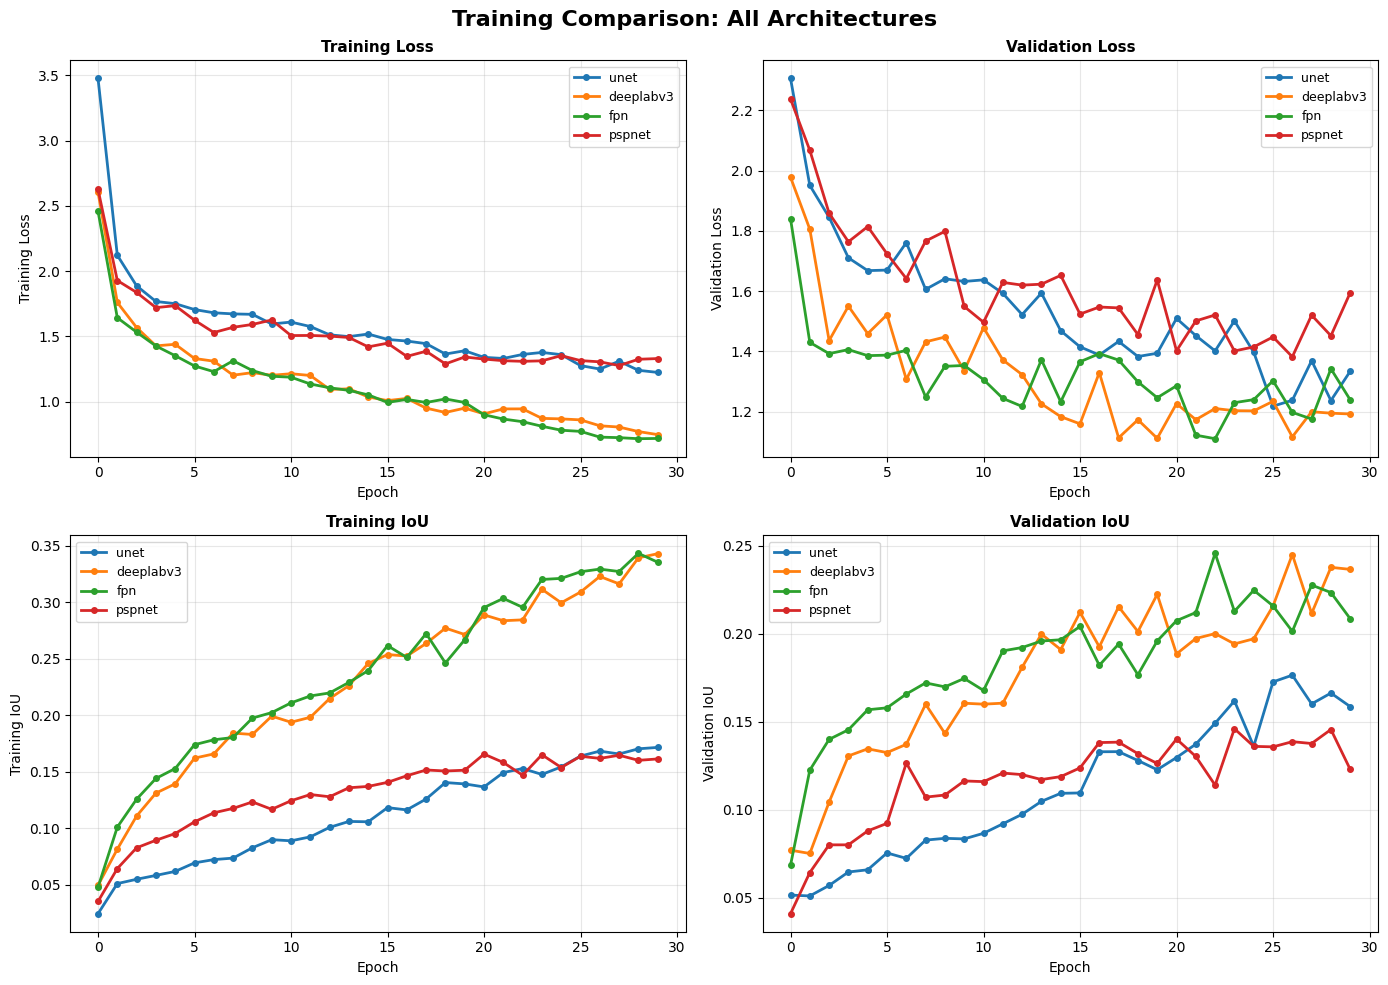


Generating individual metric plots...
  Plotting Training Loss...


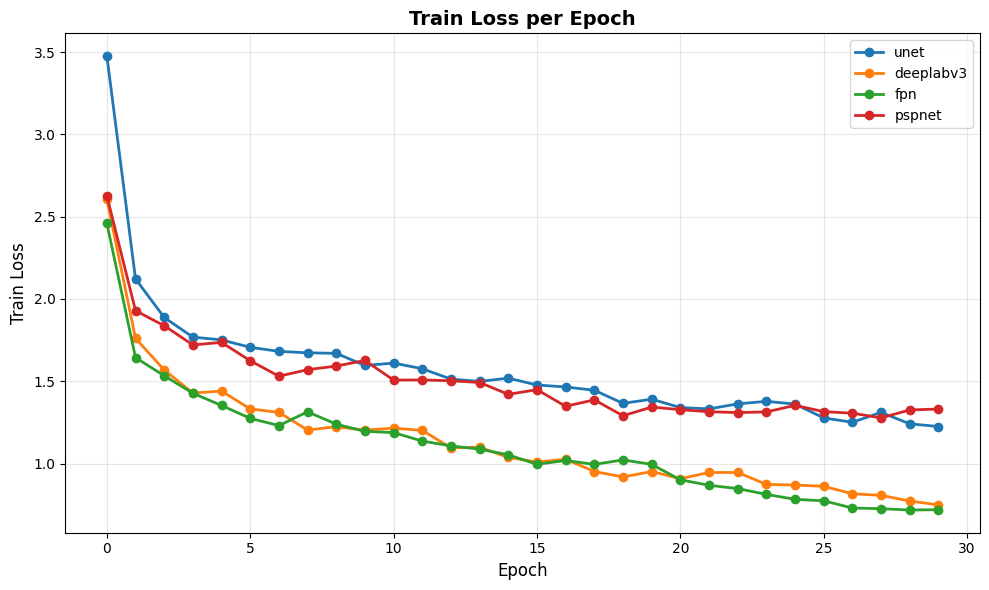

  Plotting Validation Loss...


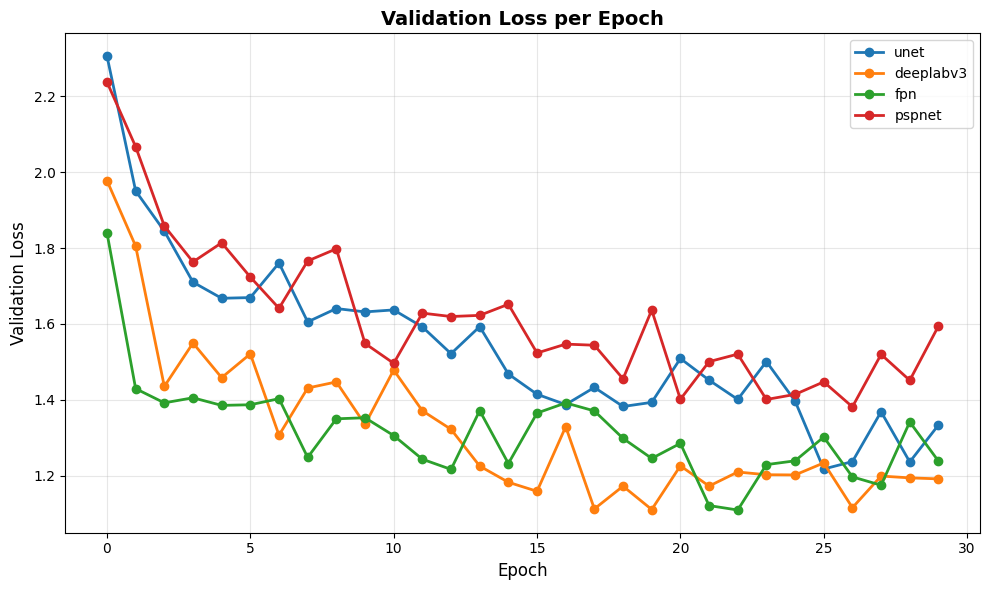

  Plotting Training IoU...


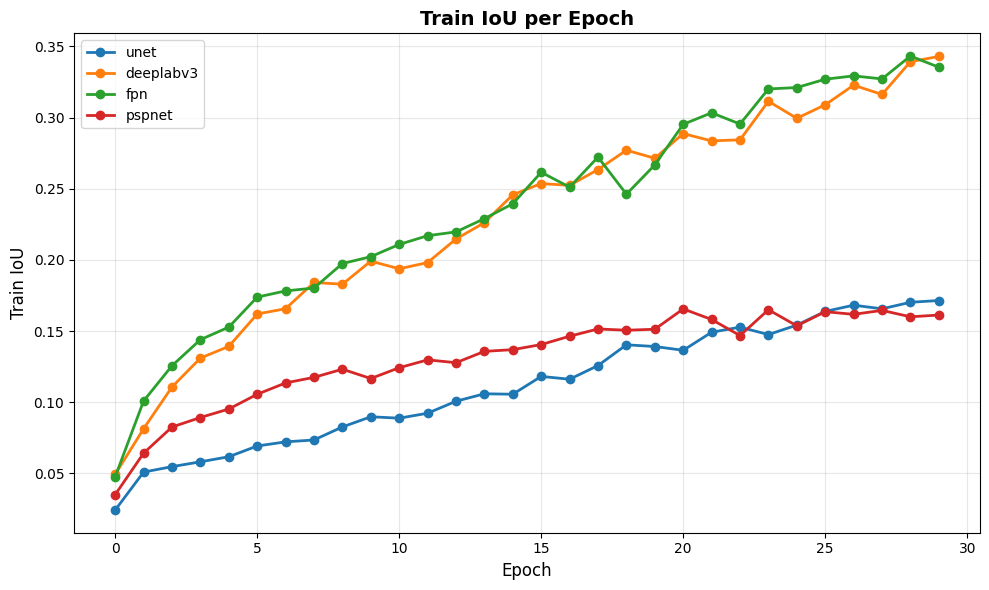

  Plotting Validation IoU...


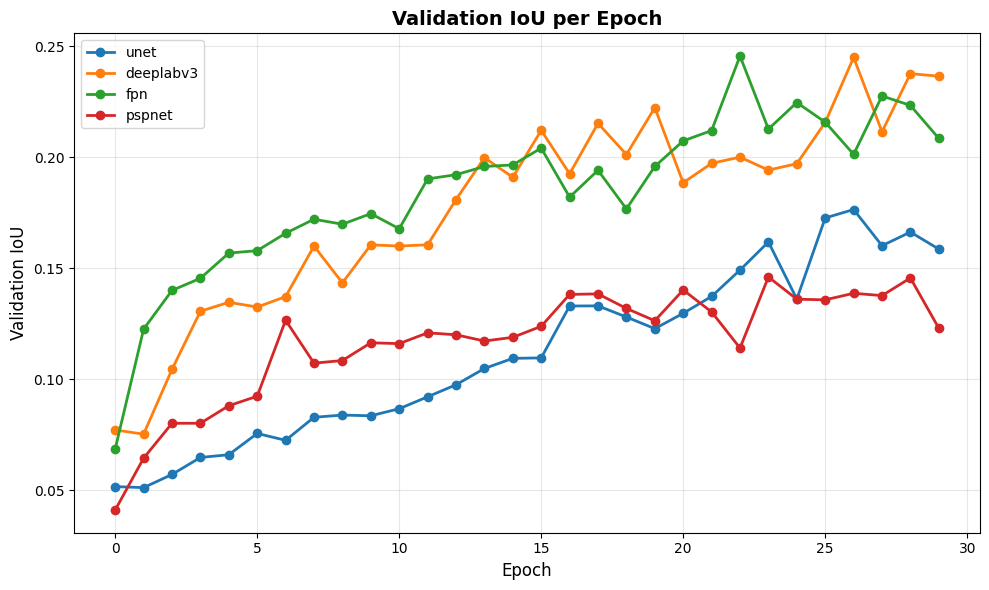

  Plotting Training Dice...


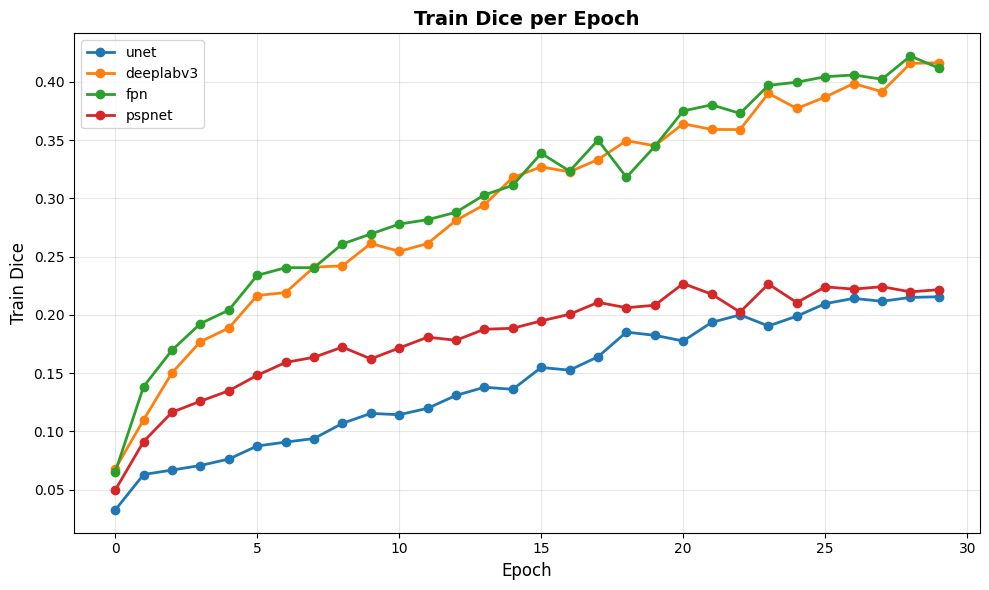

  Plotting Validation Dice...


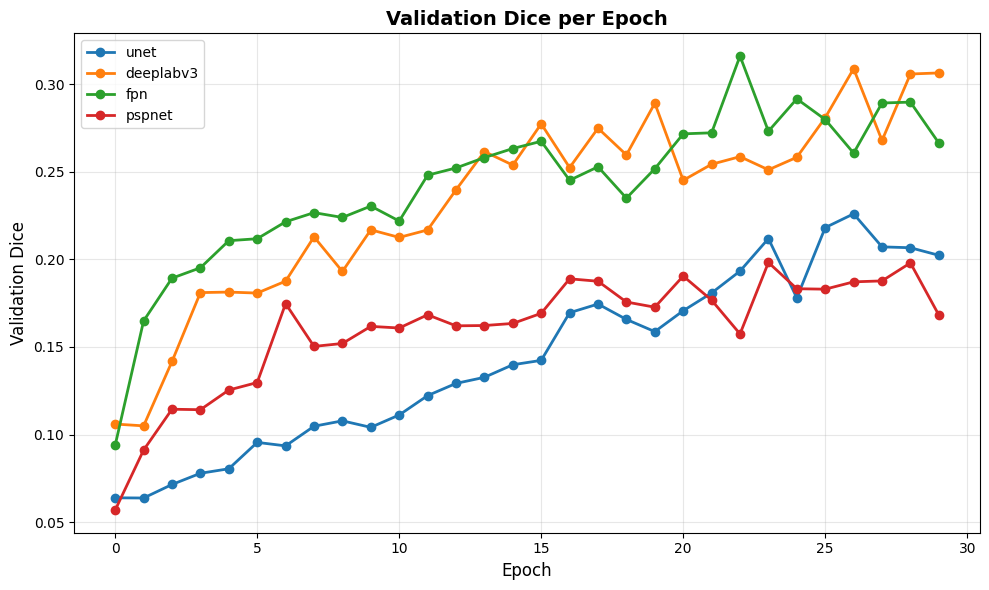

  Plotting Training Accuracy...


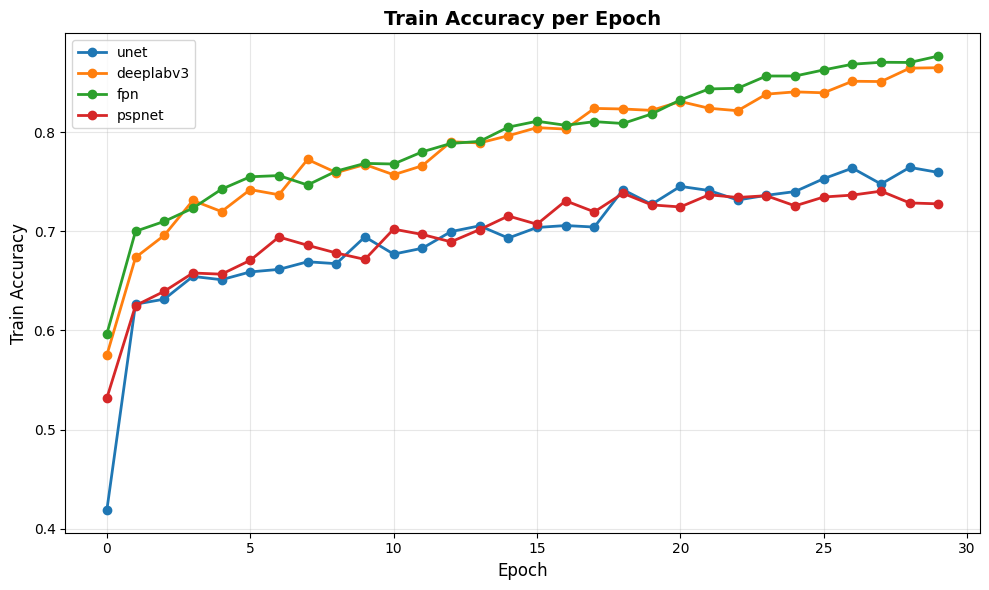

  Plotting Validation Accuracy...


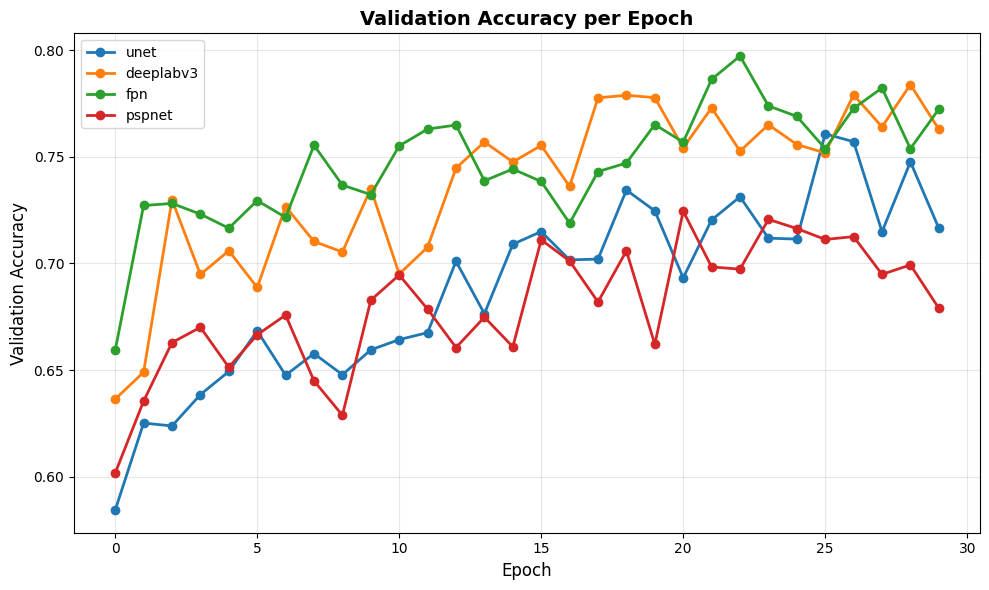


All plots generated successfully!


In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ARCHITECTURES = ['unet', 'deeplabv3', 'fpn', 'pspnet']
LOG_DIR = "experiments"

def load_metrics(arch):
    """Loads the CSV logs for a given architecture."""
    arch_path = os.path.join(LOG_DIR, arch)
    
    # Find version folder
    version_dirs = [d for d in os.listdir(arch_path) if d.startswith("version")]
    
    if not version_dirs:
        raise FileNotFoundError(f"No version folder found for architecture {arch}")
    
    version_dirs.sort()
    metrics_path = os.path.join(arch_path, version_dirs[-1], "metrics.csv")
    
    print(f"Loading: {metrics_path}")
    df = pd.read_csv(metrics_path)
    
    # Remove rows where epoch is NaN (these are intermediate logging steps)
    df = df[df["epoch"].notna()].copy()
    
    # Since each epoch has two rows (one for train, one for val), 
    # we'll aggregate by taking the last non-null value for each metric per epoch
    df_grouped = df.groupby('epoch').agg(lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan)
    df_grouped = df_grouped.reset_index()
    
    return df_grouped

def plot_metric(df_list, metric_name, ylabel, title=None):
    """Plot one metric for all architectures."""
    plt.figure(figsize=(10, 6))
    
    has_data = False
    for arch, df in df_list:
        if metric_name not in df.columns:
            print(f"  {metric_name} not found in {arch}")
            continue
        
        # Only plot if there's actual data
        data = df[metric_name].dropna()
        if len(data) > 0:
            epochs = df.loc[data.index, "epoch"]
            plt.plot(epochs, data, marker='o', label=arch, linewidth=2)
            has_data = True
    
    if not has_data:
        plt.close()
        print(f"  No data available for {metric_name}")
        return
    
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title or f"{ylabel} per Epoch", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_comparison_grid(df_list):
    """Create a 2x2 grid comparing key metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Training Comparison: All Architectures', fontsize=16, fontweight='bold')
    
    metrics = [
        ('train_loss', 'Training Loss', axes[0, 0]),
        ('val_loss', 'Validation Loss', axes[0, 1]),
        ('train_iou', 'Training IoU', axes[1, 0]),
        ('val_iou', 'Validation IoU', axes[1, 1])
    ]
    
    for metric_name, ylabel, ax in metrics:
        for arch, df in df_list:
            if metric_name not in df.columns:
                continue
            
            data = df[metric_name].dropna()
            if len(data) > 0:
                epochs = df.loc[data.index, "epoch"]
                ax.plot(epochs, data, marker='o', label=arch, linewidth=2, markersize=4)
        
        ax.set_xlabel("Epoch", fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(ylabel, fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_summary_table(df_list):
    """Print a summary table of best metrics."""
    print("\n" + "="*80)
    print("SUMMARY: Best Metrics per Architecture")
    print("="*80)
    
    summary_data = []
    for arch, df in df_list:
        row = {'Architecture': arch.upper()}
        
        # Best validation loss (minimum)
        if 'val_loss' in df.columns:
            val_loss = df['val_loss'].dropna()
            if len(val_loss) > 0:
                row['Best Val Loss'] = f"{val_loss.min():.4f}"
                row['Val Loss Epoch'] = int(df.loc[val_loss.idxmin(), 'epoch'])
        
        # Best validation IoU (maximum)
        if 'val_iou' in df.columns:
            val_iou = df['val_iou'].dropna()
            if len(val_iou) > 0:
                row['Best Val IoU'] = f"{val_iou.max():.4f}"
                row['Val IoU Epoch'] = int(df.loc[val_iou.idxmax(), 'epoch'])
        
        # Best validation accuracy (maximum)
        if 'val_acc' in df.columns:
            val_acc = df['val_acc'].dropna()
            if len(val_acc) > 0:
                row['Best Val Acc'] = f"{val_acc.max():.4f}"
        
        # Best validation dice (maximum)
        if 'val_dice' in df.columns:
            val_dice = df['val_dice'].dropna()
            if len(val_dice) > 0:
                row['Best Val Dice'] = f"{val_dice.max():.4f}"
        
        summary_data.append(row)
    
    # Print as table
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        print("="*80 + "\n")

if __name__ == "__main__":
    df_arch = []
    
    print("="*80)
    print("Loading metrics from all architectures...")
    print("="*80 + "\n")
    
    # Load all logs
    for arch in ARCHITECTURES:
        try:
            df = load_metrics(arch)
            df_arch.append((arch, df))
            print(f"  ✓ {arch}: {len(df)} epochs loaded\n")
        except Exception as e:
            print(f"  ✗ Skipping {arch}: {e}\n")
    
    if not df_arch:
        print("ERROR: No data loaded. Please check your experiments directory.")
        exit(1)
    
    # Print summary table
    print_summary_table(df_arch)
    
    # Create comparison grid
    print("Generating comparison grid...")
    plot_comparison_grid(df_arch)
    
    # Plot individual metrics
    print("\nGenerating individual metric plots...")
    
    print("  Plotting Training Loss...")
    plot_metric(df_arch, "train_loss", "Train Loss")
    
    print("  Plotting Validation Loss...")
    plot_metric(df_arch, "val_loss", "Validation Loss")
    
    print("  Plotting Training IoU...")
    plot_metric(df_arch, "train_iou", "Train IoU")
    
    print("  Plotting Validation IoU...")
    plot_metric(df_arch, "val_iou", "Validation IoU")
    
    print("  Plotting Training Dice...")
    plot_metric(df_arch, "train_dice", "Train Dice")
    
    print("  Plotting Validation Dice...")
    plot_metric(df_arch, "val_dice", "Validation Dice")
    
    print("  Plotting Training Accuracy...")
    plot_metric(df_arch, "train_acc", "Train Accuracy")
    
    print("  Plotting Validation Accuracy...")
    plot_metric(df_arch, "val_acc", "Validation Accuracy")
    
    print("\n" + "="*80)
    print("All plots generated successfully!")
    print("="*80)

Loaded 59 class names

Loading metrics from all architectures...

Loading: experiments/unet/version_0/metrics.csv
  ✓ unet: 30 epochs loaded

Loading: experiments/deeplabv3/version_0/metrics.csv
  ✓ deeplabv3: 30 epochs loaded

Loading: experiments/fpn/version_0/metrics.csv
  ✓ fpn: 30 epochs loaded

Loading: experiments/pspnet/version_0/metrics.csv
  ✓ pspnet: 30 epochs loaded


PER-CLASS IoU SUMMARY (VAL SET)
 Class        Name DEEPLABV3   FPN PSPNET  UNET  Mean      Best
     0        null     0.959 0.963  0.905 0.956 0.946       FPN
     1 accessories     0.099 0.058  0.019     - 0.059 DEEPLABV3
     2         bag     0.422 0.297  0.048 0.194 0.240 DEEPLABV3
     3        belt     0.191 0.328  0.177     - 0.232       FPN
     4      blazer     0.018 0.001  0.001     - 0.007 DEEPLABV3
     5      blouse     0.333 0.212  0.126 0.148 0.205 DEEPLABV3
     7       boots         - 0.031  0.055     - 0.043    PSPNET
    10        cape     0.126     -  0.005     - 0.065 DEEPLABV3
    13   

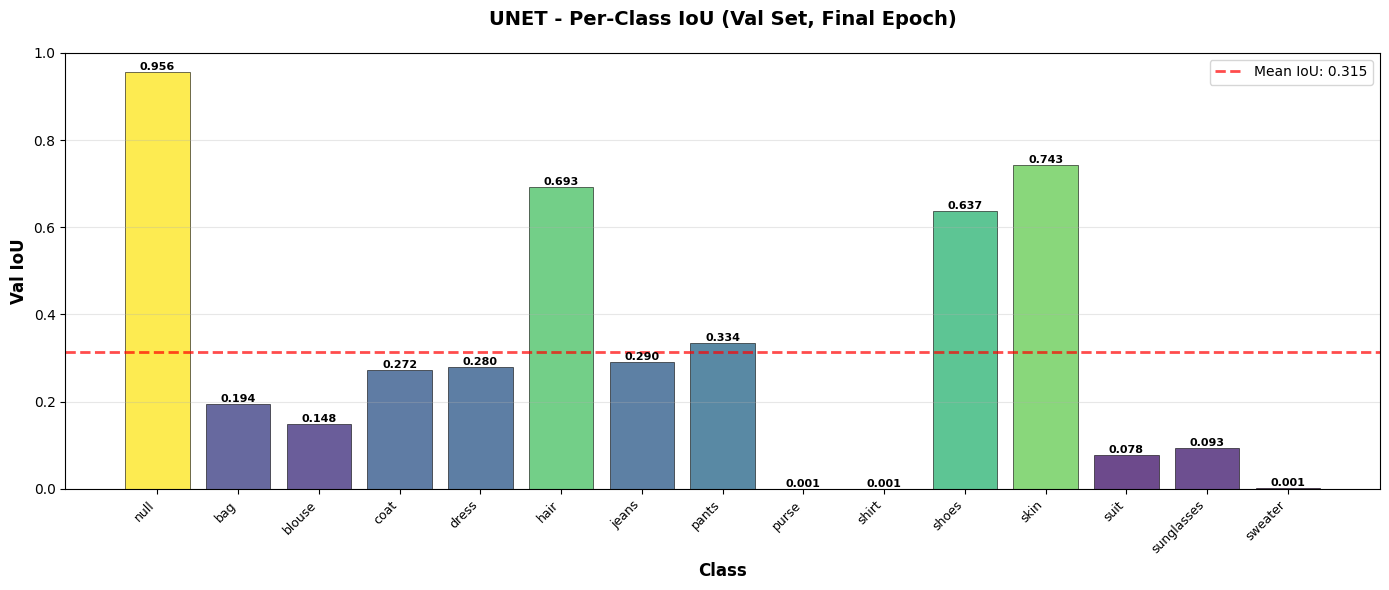

Plotting DEEPLABV3...


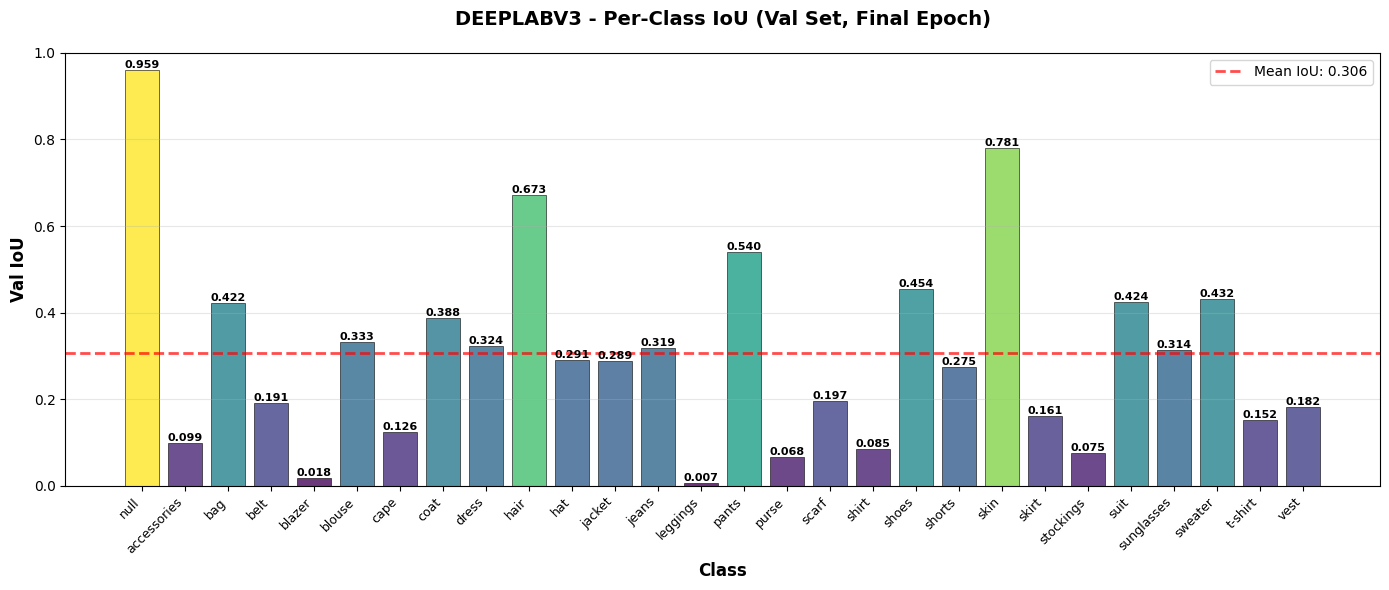

Plotting FPN...


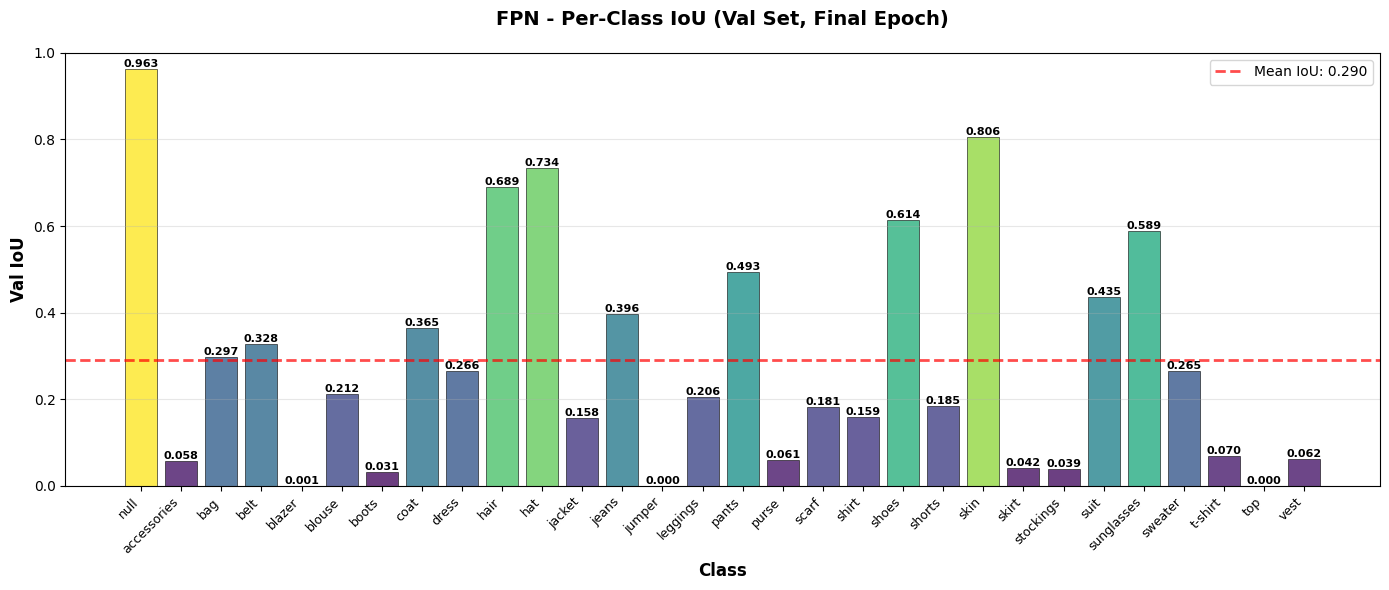

Plotting PSPNET...


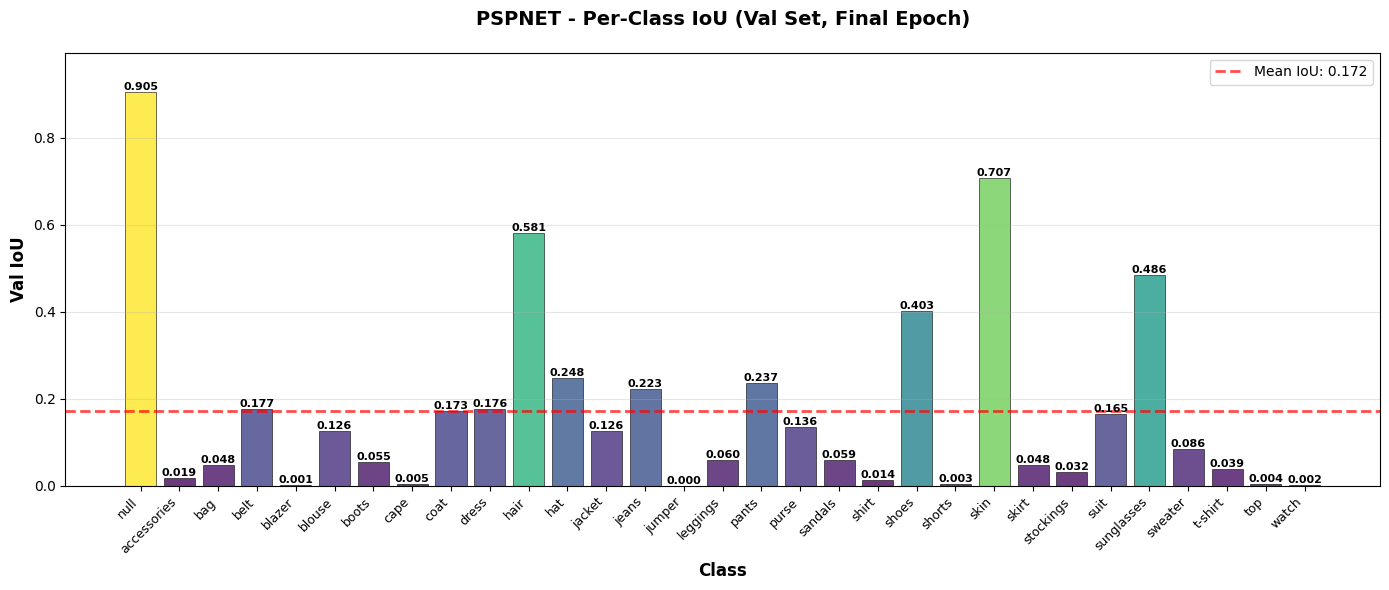


Generating comparison chart...



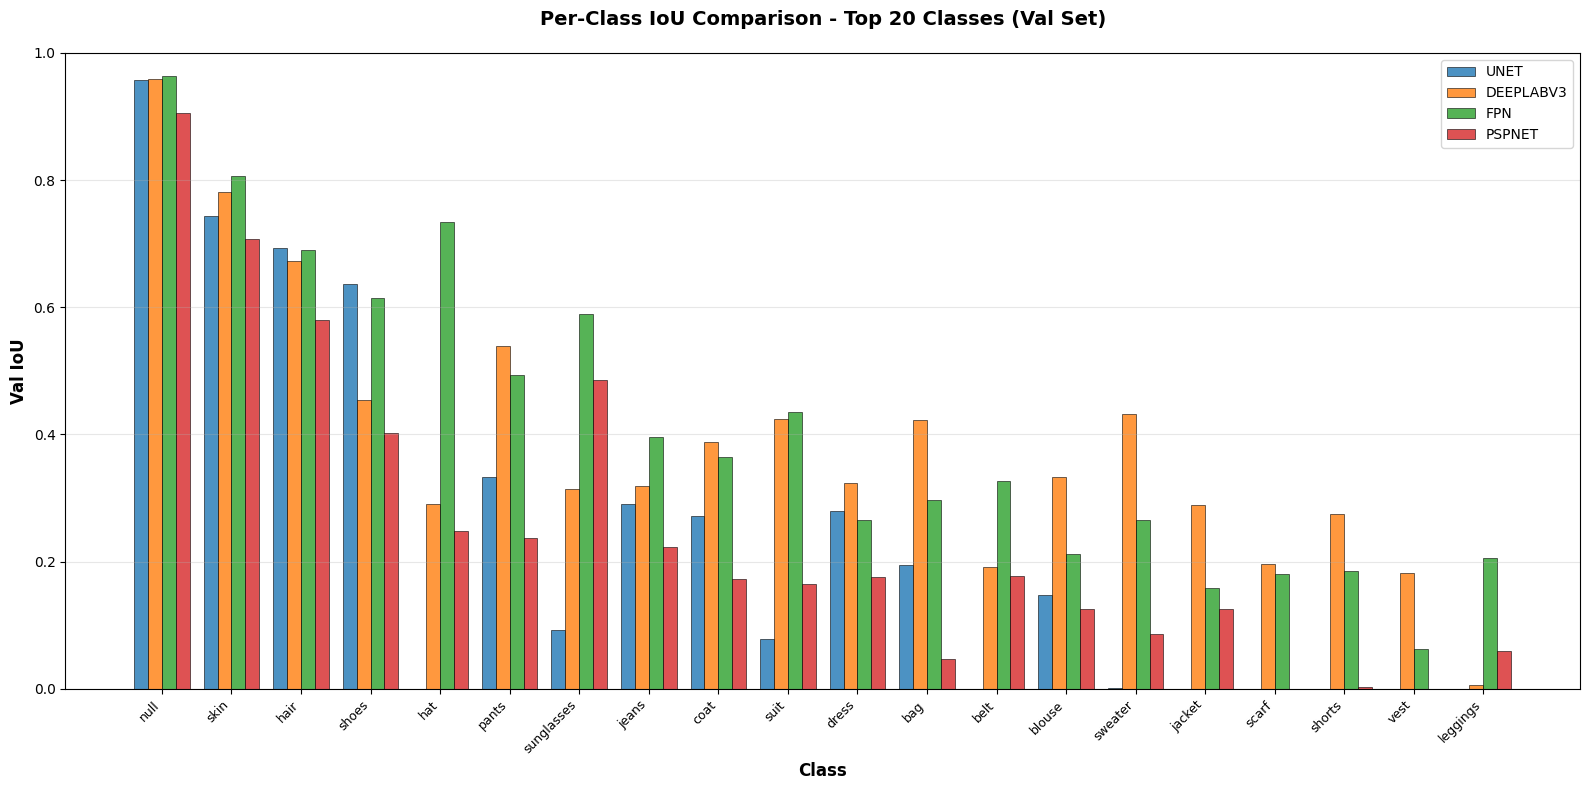


Generating per-class IoU bar charts for each architecture (Training Set)...

Plotting UNET (train)...
  All classes have zero IoU for unet (train)
Plotting DEEPLABV3 (train)...
  All classes have zero IoU for deeplabv3 (train)
Plotting FPN (train)...
  All classes have zero IoU for fpn (train)
Plotting PSPNET (train)...
  All classes have zero IoU for pspnet (train)

All per-class visualizations generated successfully!


In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ARCHITECTURES = ['unet', 'deeplabv3', 'fpn', 'pspnet']
LOG_DIR = "experiments"
CLASS_DICT_PATH = 'clothes/class_dict.csv'

def load_class_names(class_dict_path):
    """Load class names from class_dict.csv"""
    try:
        class_df = pd.read_csv(class_dict_path)
        # The CSV has 'class_name' column
        if 'class_name' in class_df.columns:
            # Convert to list and handle NaN values
            class_names = class_df['class_name'].tolist()
            # Replace NaN with "null" or similar
            class_names = [name if pd.notna(name) else "null" for name in class_names]
            return class_names
        elif 'name' in class_df.columns:
            class_names = class_df['name'].tolist()
            class_names = [name if pd.notna(name) else "null" for name in class_names]
            return class_names
        else:
            # If no name column, use index
            return [f"Class {i}" for i in range(len(class_df))]
    except Exception as e:
        print(f"Warning: Could not load class names: {e}")
        return None

def load_metrics(arch):
    """Loads the CSV logs for a given architecture."""
    arch_path = os.path.join(LOG_DIR, arch)
    
    # Find version folder
    version_dirs = [d for d in os.listdir(arch_path) if d.startswith("version")]
    
    if not version_dirs:
        raise FileNotFoundError(f"No version folder found for architecture {arch}")
    
    version_dirs.sort()
    metrics_path = os.path.join(arch_path, version_dirs[-1], "metrics.csv")
    
    print(f"Loading: {metrics_path}")
    df = pd.read_csv(metrics_path)
    
    # Remove rows where epoch is NaN
    df = df[df["epoch"].notna()].copy()
    
    # Group by epoch and take last non-null value
    df_grouped = df.groupby('epoch').agg(lambda x: x.dropna().iloc[-1] if len(x.dropna()) > 0 else np.nan)
    df_grouped = df_grouped.reset_index()
    
    return df_grouped

def extract_per_class_iou(df, split='val'):
    """Extract per-class IoU metrics for train or val split."""
    # Find all columns matching the pattern
    iou_cols = [col for col in df.columns if col.startswith(f'{split}_iou_class_')]
    
    if not iou_cols:
        return None, None
    
    # Extract class numbers
    class_indices = []
    for col in iou_cols:
        class_num = int(col.split('_')[-1])
        class_indices.append(class_num)
    
    # Sort by class index
    sorted_pairs = sorted(zip(class_indices, iou_cols))
    class_indices, iou_cols = zip(*sorted_pairs)
    
    # Get the last epoch's values
    last_epoch_idx = df['epoch'].idxmax()
    iou_values = df.loc[last_epoch_idx, list(iou_cols)].values
    
    return list(class_indices), iou_values

def plot_per_class_iou_single_arch(arch, df, class_names=None, split='val'):
    """Create bar chart for per-class IoU for a single architecture."""
    class_indices, iou_values = extract_per_class_iou(df, split=split)
    
    if class_indices is None:
        print(f"  No {split} per-class IoU data for {arch}")
        return
    
    # Filter out classes with zero IoU for cleaner visualization
    non_zero_mask = iou_values > 0
    if not np.any(non_zero_mask):
        print(f"  All classes have zero IoU for {arch} ({split})")
        return
    
    filtered_indices = np.array(class_indices)[non_zero_mask]
    filtered_values = iou_values[non_zero_mask]
    
    # Prepare labels
    if class_names and len(class_names) > max(filtered_indices):
        labels = [class_names[i] for i in filtered_indices]
    else:
        labels = [f"Class {i}" for i in filtered_indices]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create bar chart
    x_pos = np.arange(len(filtered_indices))
    colors = plt.cm.viridis(filtered_values / filtered_values.max())
    bars = ax.bar(x_pos, filtered_values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Customize plot
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{split.capitalize()} IoU', fontsize=12, fontweight='bold')
    ax.set_title(f'{arch.upper()} - Per-Class IoU ({split.capitalize()} Set, Final Epoch)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, min(1.0, filtered_values.max() * 1.1))
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, filtered_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Add statistics
    mean_iou = filtered_values.mean()
    ax.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, 
               label=f'Mean IoU: {mean_iou:.3f}', alpha=0.7)
    ax.legend(fontsize=10, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_per_class_comparison(df_list, class_names=None, split='val', top_n=20):
    """Create a comparison bar chart showing per-class IoU for all architectures."""
    # Collect data for all architectures
    arch_data = {}
    all_classes = set()
    
    for arch, df in df_list:
        class_indices, iou_values = extract_per_class_iou(df, split=split)
        if class_indices is not None:
            arch_data[arch] = dict(zip(class_indices, iou_values))
            all_classes.update(class_indices)
    
    if not arch_data:
        print(f"No {split} per-class IoU data available")
        return
    
    # Sort classes and limit to top_n by average IoU
    all_classes = sorted(all_classes)
    class_avg_iou = {}
    for cls in all_classes:
        values = [arch_data[arch].get(cls, 0) for arch in arch_data.keys()]
        class_avg_iou[cls] = np.mean([v for v in values if v > 0] or [0])
    
    # Get top N classes by average IoU
    top_classes = sorted(class_avg_iou.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_class_indices = [cls for cls, _ in top_classes]
    
    # Prepare data for plotting
    architectures = list(arch_data.keys())
    x = np.arange(len(top_class_indices))
    width = 0.8 / len(architectures)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot bars for each architecture
    for i, arch in enumerate(architectures):
        values = [arch_data[arch].get(cls, 0) for cls in top_class_indices]
        offset = (i - len(architectures)/2 + 0.5) * width
        ax.bar(x + offset, values, width, label=arch.upper(), alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Prepare labels
    if class_names and len(class_names) > max(top_class_indices):
        labels = [class_names[i] for i in top_class_indices]
    else:
        labels = [f"Class {i}" for i in top_class_indices]
    
    # Customize plot
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{split.capitalize()} IoU', fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class IoU Comparison - Top {top_n} Classes ({split.capitalize()} Set)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()

def create_summary_table(df_list, class_names=None, split='val'):
    """Create a summary table of per-class IoU across architectures."""
    print("\n" + "="*100)
    print(f"PER-CLASS IoU SUMMARY ({split.upper()} SET)")
    print("="*100)
    
    # Collect data
    arch_data = {}
    all_classes = set()
    
    for arch, df in df_list:
        class_indices, iou_values = extract_per_class_iou(df, split=split)
        if class_indices is not None:
            arch_data[arch] = dict(zip(class_indices, iou_values))
            all_classes.update(class_indices)
    
    if not arch_data:
        print("No data available")
        return
    
    # Create summary
    all_classes = sorted(all_classes)
    summary_data = []
    
    for cls in all_classes:
        row = {'Class': cls}
        if class_names and len(class_names) > cls:
            name = class_names[cls]
            # Handle potential NaN or non-string values
            if pd.notna(name) and isinstance(name, str):
                row['Name'] = name[:20]  # Truncate long names
            else:
                row['Name'] = f"Class_{cls}"
        
        values = []
        for arch in sorted(arch_data.keys()):
            iou = arch_data[arch].get(cls, 0)
            row[arch.upper()] = f"{iou:.3f}" if iou > 0 else "-"
            if iou > 0:
                values.append(iou)
        
        if values:
            row['Mean'] = f"{np.mean(values):.3f}"
            row['Best'] = max(arch_data.keys(), key=lambda a: arch_data[a].get(cls, 0)).upper()
        
        # Only include classes that appear in at least one architecture
        if values:
            summary_data.append(row)
    
    # Print table
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))
        print("="*100 + "\n")

if __name__ == "__main__":
    # Load class names
    class_names = load_class_names(CLASS_DICT_PATH)
    if class_names:
        print(f"Loaded {len(class_names)} class names\n")
    
    # Load all metrics
    df_arch = []
    print("="*80)
    print("Loading metrics from all architectures...")
    print("="*80 + "\n")
    
    for arch in ARCHITECTURES:
        try:
            df = load_metrics(arch)
            df_arch.append((arch, df))
            print(f"  ✓ {arch}: {len(df)} epochs loaded\n")
        except Exception as e:
            print(f"  ✗ Skipping {arch}: {e}\n")
    
    if not df_arch:
        print("ERROR: No data loaded. Please check your experiments directory.")
        exit(1)
    
    # Create summary table
    create_summary_table(df_arch, class_names, split='val')
    
    # Plot individual architecture bar charts (validation set)
    print("="*80)
    print("Generating per-class IoU bar charts for each architecture (Validation Set)...")
    print("="*80 + "\n")
    
    for arch, df in df_arch:
        print(f"Plotting {arch.upper()}...")
        plot_per_class_iou_single_arch(arch, df, class_names, split='val')
    
    # Plot comparison chart
    print("\n" + "="*80)
    print("Generating comparison chart...")
    print("="*80 + "\n")
    plot_per_class_comparison(df_arch, class_names, split='val', top_n=20)
    
    # Optional: Also plot training set metrics
    print("\n" + "="*80)
    print("Generating per-class IoU bar charts for each architecture (Training Set)...")
    print("="*80 + "\n")
    
    for arch, df in df_arch:
        print(f"Plotting {arch.upper()} (train)...")
        plot_per_class_iou_single_arch(arch, df, class_names, split='train')
    
    print("\n" + "="*80)
    print("All per-class visualizations generated successfully!")
    print("="*80)